# Brain Tumor Segmentation

Download dataset from: https://www.kaggle.com/datasets/bilalakgz/brain-tumor-mri-dataset

In [1]:
import os
import random
from glob import glob
from collections import Counter
import copy

# Image Processing and Visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Scikit-Learn Metrics for Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Progress Display
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/mydrive')

Mounted at /mydrive


##### Data Preprocessing

In [3]:
train_image_dir = '/mydrive/MyDrive/brain_tumor_dataset/training/images'
train_gt_dir = '/mydrive/MyDrive/brain_tumor_dataset/training/labels'
val_image_dir = '/mydrive/MyDrive/brain_tumor_dataset/validation/images'
val_gt_dir = '/mydrive/MyDrive/brain_tumor_dataset/validation/labels'
test_image_dir = '/mydrive/MyDrive/brain_tumor_dataset/testing/images'
test_gt_dir = '/mydrive/MyDrive/brain_tumor_dataset/testing/labels'

In [4]:
def get_image_sizes(folder_path: str):
    sizes = {}

    for filename in os.listdir(folder_path):
        try:
            if filename.endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img.shape not in sizes:
                    sizes[img.shape] = 1
                else:
                    sizes[img.shape] += 1
        except Exception as e:
            print(f"Error opening {filename}: {e}")

    return sizes

print(get_image_sizes(train_image_dir))
print(get_image_sizes(train_gt_dir))
print(get_image_sizes(val_image_dir))
print(get_image_sizes(val_gt_dir))
print(get_image_sizes(test_image_dir))
print(get_image_sizes(test_gt_dir))

{(640, 640, 3): 102}
{(369, 369, 3): 102}
{(640, 640, 3): 30}
{(369, 369, 3): 30}
{(640, 640, 3): 15}
{(369, 369, 3): 15}


##### Visualize image and label

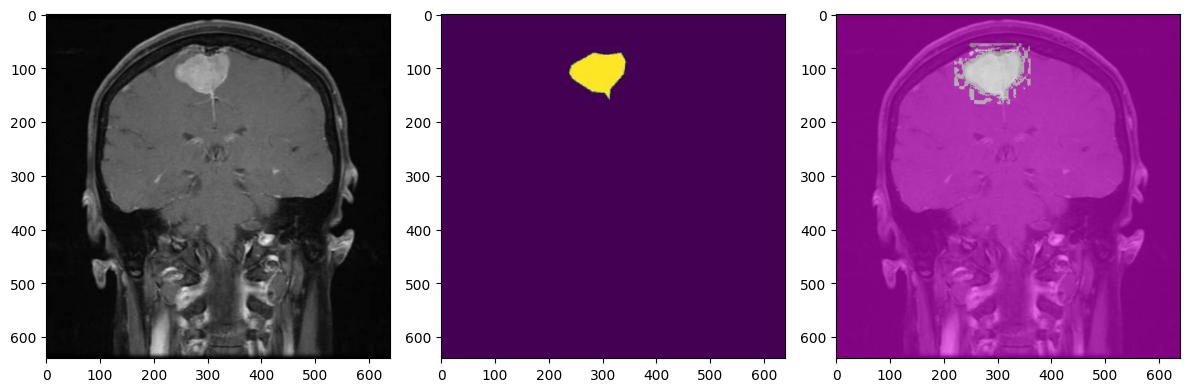

In [5]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt

folder_path1 = train_image_dir
folder_path2 = train_gt_dir

filename = random.choice(os.listdir(folder_path1))
img_path1 = os.path.join(folder_path1, filename)
img_path2 = os.path.join(folder_path2, filename)

img1 = Image.open(img_path1).convert("RGB")
img2 = Image.open(img_path2)
img2 = img2.resize(img1.size, Image.NEAREST)

mask = np.array(img2)

# unique_colors, frequencies = np.unique(mask.reshape(-1, mask.shape[-1]), axis=0, return_counts=True)
# print("Unique colors and their frequencies in the mask:")
# for color, freq in zip(unique_colors, frequencies):
#     print(f"Color: {color}, Frequency: {freq}")

colored_mask = np.zeros(mask.shape)
colored_mask[mask > 0] = [1]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].imshow(img1)

axes[1].imshow(img2)

axes[2].imshow(img1, alpha=1.0)
axes[2].imshow(colored_mask, alpha=0.5)

plt.tight_layout()
plt.show()

##### Create Pytorch Dataset

In [6]:
from torch.utils.data import Dataset
import torch
import cv2
import torchvision.transforms as tt

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class TumorDataset(Dataset):
    def __init__(self, img_dir: str, mask_dir: str, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      img_file = self.image_paths[idx]
      base_name = os.path.splitext(os.path.basename(img_file))[0]
      img_file = os.path.join(self.img_dir, img_file)
      mask_file = os.path.join(self.mask_dir, base_name + '.jpg')

      # Load the image and mask
      img = cv2.imread(img_file)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_AREA)

      # Create a new mask with binary values
      new_mask = np.zeros(mask.shape)
      new_mask[mask == 215] = 1  # Set 1 for target mask value

      # Normalize the image values to [0, 1]
      img = img / 255.0

      # Apply transformations if specified
      if self.transform:
          augmented = self.transform(image=img, mask=new_mask)
          img, new_mask = augmented['image'], augmented['mask']

      # Normalize the image using mean and std
      img = tt.Normalize(mean, std)(torch.tensor(img).permute(2, 0, 1))  # Transform image to tensor before normalization

      # Convert to PyTorch tensors
      img_tensor = img.float()  # Image should already be normalized
      mask_tensor = torch.from_numpy(new_mask).long()  # Mask should be a tensor

      return img_tensor, mask_tensor

In [7]:
import albumentations as A

train_transforms = A.Compose([
    A.Resize(256, 256),
])

val_transforms = A.Compose([
    A.Resize(256, 256),
])

test_transforms = A.Compose([
    A.Resize(256, 256),
])



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##### Create Dataloaders

In [8]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = TumorDataset(train_image_dir, train_gt_dir, transform=train_transforms)
val_dataset = TumorDataset(val_image_dir, val_gt_dir, transform=val_transforms)
test_dataset = TumorDataset(test_image_dir, test_gt_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

##### Training Function

In [9]:
from tqdm import tqdm

def training(model, num_epochs, criterion, optimizer, filename):
  min_val_loss = np.inf
  min_val_loss_epoch = 0

  train_losses = []
  val_losses = []

  for epoch in tqdm(range(num_epochs)):
      model.train()
      train_loss = 0
      for imgs, masks in train_loader:
          imgs = imgs.cuda()
          masks = masks.cuda()
          optimizer.zero_grad()
          outputs = model(imgs)
          loss = criterion(outputs, masks)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
      train_loss /= len(train_loader)
      train_losses.append(train_loss)

      # Validation step
      model.eval()
      val_loss = 0
      with torch.no_grad():
          for imgs, masks in val_loader:
              imgs = imgs.cuda()
              masks = masks.cuda()
              outputs = model(imgs)
              loss = criterion(outputs, masks)
              val_loss += loss.item()
      val_loss /= len(val_loader)
      val_losses.append(val_loss)

      if val_loss < min_val_loss:
          min_val_loss = val_loss
          min_val_loss_epoch = epoch + 1
          torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch, 'loss': loss,}, filename)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

  print(f"Epoch {min_val_loss_epoch}, Minimum Validation Loss: {min_val_loss}")
  return train_losses, val_losses

In [10]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=2aaf91c3527fe0b5be43271bb855c0c98e1968ad582bd003b85ef4e44ae46235
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a041a72a059371a12197fb1452030b0243020b4161f3f5af2160e89f70d73af2
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

## Training U-Net

In [11]:
num_epochs = 100
learning_rate = 1e-4

from segmentation_models_pytorch import Unet
model = Unet(encoder_name='resnet18', in_channels=3, classes=2).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 435MB/s]


In [12]:
losses = training(model, train_loader, val_loader, num_epochs, criterion, optimizer, 'ResUnet.pth')

  1%|          | 1/100 [00:04<07:41,  4.66s/it]

Epoch 1/100, Train Loss: 0.7114068780626569, Validation Loss: 1.3633944153785706


  2%|▏         | 2/100 [00:07<05:50,  3.57s/it]

Epoch 2/100, Train Loss: 0.5833372473716736, Validation Loss: 1.3570067326227824


  3%|▎         | 3/100 [00:10<05:40,  3.52s/it]

Epoch 3/100, Train Loss: 0.48894388335091726, Validation Loss: 0.5905452032883962


  4%|▍         | 4/100 [00:14<05:21,  3.35s/it]

Epoch 4/100, Train Loss: 0.41496401599475313, Validation Loss: 0.4136991212765376


  5%|▌         | 5/100 [00:17<05:07,  3.23s/it]

Epoch 5/100, Train Loss: 0.36904335021972656, Validation Loss: 0.3574443648258845


  6%|▌         | 6/100 [00:20<05:02,  3.21s/it]

Epoch 6/100, Train Loss: 0.3285845858710153, Validation Loss: 0.3373370885848999


  7%|▋         | 7/100 [00:23<04:52,  3.15s/it]

Epoch 7/100, Train Loss: 0.29929408856800627, Validation Loss: 0.29883122940858203


  8%|▊         | 8/100 [00:26<04:47,  3.12s/it]

Epoch 8/100, Train Loss: 0.27256342342921663, Validation Loss: 0.27037126074234646


  9%|▉         | 9/100 [00:29<04:42,  3.10s/it]

Epoch 9/100, Train Loss: 0.2508210390806198, Validation Loss: 0.24740196367104847


 10%|█         | 10/100 [00:32<04:37,  3.08s/it]

Epoch 10/100, Train Loss: 0.23182423625673568, Validation Loss: 0.23445926159620284


 11%|█         | 11/100 [00:35<04:32,  3.06s/it]

Epoch 11/100, Train Loss: 0.21760015402521407, Validation Loss: 0.22060962120691935


 12%|█▏        | 12/100 [00:38<04:30,  3.07s/it]

Epoch 12/100, Train Loss: 0.2038921160357339, Validation Loss: 0.20765104045470556


 13%|█▎        | 13/100 [00:41<04:24,  3.04s/it]

Epoch 13/100, Train Loss: 0.19058895536831447, Validation Loss: 0.19618735760450362


 14%|█▍        | 14/100 [00:44<04:18,  3.01s/it]

Epoch 14/100, Train Loss: 0.18115003832748958, Validation Loss: 0.18694069782892864


 15%|█▌        | 15/100 [00:47<04:14,  3.00s/it]

Epoch 15/100, Train Loss: 0.1709382746900831, Validation Loss: 0.1783341904481252


 16%|█▌        | 16/100 [00:50<04:11,  3.00s/it]

Epoch 16/100, Train Loss: 0.1656587826354163, Validation Loss: 0.17029386411110561


 17%|█▋        | 17/100 [00:53<04:09,  3.01s/it]

Epoch 17/100, Train Loss: 0.15973127952643804, Validation Loss: 0.16324582646290461


 18%|█▊        | 18/100 [00:56<04:05,  2.99s/it]

Epoch 18/100, Train Loss: 0.15208624516214644, Validation Loss: 0.15641701072454453


 19%|█▉        | 19/100 [00:59<04:04,  3.02s/it]

Epoch 19/100, Train Loss: 0.14352273515292577, Validation Loss: 0.14993871351083118


 20%|██        | 20/100 [01:02<04:02,  3.04s/it]

Epoch 20/100, Train Loss: 0.1385569338287626, Validation Loss: 0.14493322471777598


 21%|██        | 21/100 [01:05<03:58,  3.03s/it]

Epoch 21/100, Train Loss: 0.13286575036389486, Validation Loss: 0.13747831359505652


 22%|██▏       | 22/100 [01:08<03:55,  3.02s/it]

Epoch 22/100, Train Loss: 0.12709570569651468, Validation Loss: 0.13263556535045307


 23%|██▎       | 23/100 [01:11<03:53,  3.03s/it]

Epoch 23/100, Train Loss: 0.12493349718196052, Validation Loss: 0.1286504087348779


 24%|██▍       | 24/100 [01:14<03:51,  3.05s/it]

Epoch 24/100, Train Loss: 0.11794353915112359, Validation Loss: 0.12396660521626472


 25%|██▌       | 25/100 [01:17<03:49,  3.06s/it]

Epoch 25/100, Train Loss: 0.11310584843158722, Validation Loss: 0.11900527601440748


 26%|██▌       | 26/100 [01:20<03:44,  3.04s/it]

Epoch 26/100, Train Loss: 0.10924465528556279, Validation Loss: 0.11460747892657916


 27%|██▋       | 27/100 [01:23<03:41,  3.04s/it]

Epoch 27/100, Train Loss: 0.10622520851237434, Validation Loss: 0.11227220073342323


 28%|██▊       | 28/100 [01:26<03:37,  3.02s/it]

Epoch 28/100, Train Loss: 0.10226379867110934, Validation Loss: 0.1076115146279335


 29%|██▉       | 29/100 [01:29<03:35,  3.03s/it]

Epoch 29/100, Train Loss: 0.09857489807265145, Validation Loss: 0.10530128329992294


 30%|███       | 30/100 [01:32<03:29,  3.00s/it]

Epoch 30/100, Train Loss: 0.0944540309054511, Validation Loss: 0.10181828886270523


 31%|███       | 31/100 [01:35<03:26,  2.99s/it]

Epoch 31/100, Train Loss: 0.09136273605482918, Validation Loss: 0.0975003662208716


 32%|███▏      | 32/100 [01:38<03:22,  2.98s/it]

Epoch 32/100, Train Loss: 0.08833936495440346, Validation Loss: 0.09512061675389608


 33%|███▎      | 33/100 [01:41<03:20,  3.00s/it]

Epoch 33/100, Train Loss: 0.085488033081804, Validation Loss: 0.09200312246878942


 34%|███▍      | 34/100 [01:44<03:17,  3.00s/it]

Epoch 34/100, Train Loss: 0.08255461177655629, Validation Loss: 0.09012029940883319


 35%|███▌      | 35/100 [01:47<03:11,  2.94s/it]

Epoch 35/100, Train Loss: 0.08123345034463066, Validation Loss: 0.08878614033261935


 36%|███▌      | 36/100 [01:50<03:07,  2.92s/it]

Epoch 36/100, Train Loss: 0.07735020773751396, Validation Loss: 0.08497389232118925


 37%|███▋      | 37/100 [01:53<03:04,  2.93s/it]

Epoch 37/100, Train Loss: 0.07542670518159866, Validation Loss: 0.08383482123414675


 38%|███▊      | 38/100 [01:56<03:02,  2.95s/it]

Epoch 38/100, Train Loss: 0.07536288670131139, Validation Loss: 0.08258444691697757


 39%|███▉      | 39/100 [01:59<02:57,  2.90s/it]

Epoch 39/100, Train Loss: 0.07183562857764107, Validation Loss: 0.07992331435283025


 40%|████      | 40/100 [02:02<02:55,  2.92s/it]

Epoch 40/100, Train Loss: 0.06947388606412071, Validation Loss: 0.07725196306904157


 41%|████      | 41/100 [02:04<02:52,  2.92s/it]

Epoch 41/100, Train Loss: 0.06791883494172778, Validation Loss: 0.0741087647775809


 42%|████▏     | 42/100 [02:08<02:52,  2.98s/it]

Epoch 42/100, Train Loss: 0.06505588122776576, Validation Loss: 0.07341805386046568


 43%|████▎     | 43/100 [02:11<02:48,  2.96s/it]

Epoch 43/100, Train Loss: 0.06300389819911548, Validation Loss: 0.06996025120218595


 44%|████▍     | 44/100 [02:13<02:41,  2.88s/it]

Epoch 44/100, Train Loss: 0.06163667781012399, Validation Loss: 0.07174257785081864


 45%|████▌     | 45/100 [02:16<02:34,  2.82s/it]

Epoch 45/100, Train Loss: 0.05965908829654966, Validation Loss: 0.0673253736148278


 46%|████▌     | 46/100 [02:19<02:33,  2.83s/it]

Epoch 46/100, Train Loss: 0.05781770550778934, Validation Loss: 0.06582984440028668


 47%|████▋     | 47/100 [02:21<02:26,  2.77s/it]

Epoch 47/100, Train Loss: 0.05563470401934215, Validation Loss: 0.06636465154588223


 48%|████▊     | 48/100 [02:24<02:20,  2.71s/it]

Epoch 48/100, Train Loss: 0.05589689899768148, Validation Loss: 0.0627605972190698


 49%|████▉     | 49/100 [02:26<02:15,  2.66s/it]

Epoch 49/100, Train Loss: 0.05348212431584086, Validation Loss: 0.0635446697473526


 50%|█████     | 50/100 [02:29<02:11,  2.62s/it]

Epoch 50/100, Train Loss: 0.05186077366982188, Validation Loss: 0.06250103699664275


 51%|█████     | 51/100 [02:32<02:13,  2.73s/it]

Epoch 51/100, Train Loss: 0.05025871044823101, Validation Loss: 0.05962625741958618


 52%|█████▏    | 52/100 [02:35<02:14,  2.80s/it]

Epoch 52/100, Train Loss: 0.04977366966860635, Validation Loss: 0.05942486015458902


 53%|█████▎    | 53/100 [02:38<02:13,  2.85s/it]

Epoch 53/100, Train Loss: 0.048174655863216946, Validation Loss: 0.059090895826617876


 54%|█████▍    | 54/100 [02:41<02:12,  2.88s/it]

Epoch 54/100, Train Loss: 0.0482095650264195, Validation Loss: 0.056256088366111116


 55%|█████▌    | 55/100 [02:44<02:06,  2.81s/it]

Epoch 55/100, Train Loss: 0.04641363929424967, Validation Loss: 0.05687993181248506


 56%|█████▌    | 56/100 [02:46<02:01,  2.76s/it]

Epoch 56/100, Train Loss: 0.04511632450989315, Validation Loss: 0.05496695612867673


 57%|█████▋    | 57/100 [02:49<02:00,  2.81s/it]

Epoch 57/100, Train Loss: 0.044058176555803845, Validation Loss: 0.05401481464505196


 58%|█████▊    | 58/100 [02:52<02:00,  2.87s/it]

Epoch 58/100, Train Loss: 0.04328884503671101, Validation Loss: 0.05398145553966363


 59%|█████▉    | 59/100 [02:55<02:02,  2.99s/it]

Epoch 59/100, Train Loss: 0.04253524807947023, Validation Loss: 0.05230921171605587


 60%|██████    | 60/100 [02:58<01:56,  2.91s/it]

Epoch 60/100, Train Loss: 0.04160260249461446, Validation Loss: 0.05240318439900875


 61%|██████    | 61/100 [03:01<01:51,  2.86s/it]

Epoch 61/100, Train Loss: 0.04052005016377994, Validation Loss: 0.051095679650704065


 62%|██████▏   | 62/100 [03:03<01:45,  2.77s/it]

Epoch 62/100, Train Loss: 0.039786016302449365, Validation Loss: 0.04885414478679498


 63%|██████▎   | 63/100 [03:06<01:41,  2.73s/it]

Epoch 63/100, Train Loss: 0.03876857565982001, Validation Loss: 0.051941565424203875


 64%|██████▍   | 64/100 [03:09<01:36,  2.67s/it]

Epoch 64/100, Train Loss: 0.03864768732871328, Validation Loss: 0.0481061115860939


 65%|██████▌   | 65/100 [03:11<01:34,  2.69s/it]

Epoch 65/100, Train Loss: 0.0385795815714768, Validation Loss: 0.048338340347011885


 66%|██████▌   | 66/100 [03:14<01:30,  2.67s/it]

Epoch 66/100, Train Loss: 0.036486116370984485, Validation Loss: 0.047610146428147954


 67%|██████▋   | 67/100 [03:17<01:30,  2.74s/it]

Epoch 67/100, Train Loss: 0.036284148160900385, Validation Loss: 0.046584949269890784


 68%|██████▊   | 68/100 [03:20<01:29,  2.80s/it]

Epoch 68/100, Train Loss: 0.03655877549733434, Validation Loss: 0.046225564305981


 69%|██████▉   | 69/100 [03:23<01:29,  2.88s/it]

Epoch 69/100, Train Loss: 0.036062438040971756, Validation Loss: 0.045520295451084776


 70%|███████   | 70/100 [03:26<01:27,  2.93s/it]

Epoch 70/100, Train Loss: 0.03453024210674422, Validation Loss: 0.0453731581568718


 71%|███████   | 71/100 [03:29<01:25,  2.93s/it]

Epoch 71/100, Train Loss: 0.03346682073814528, Validation Loss: 0.044874647508064906


 72%|███████▏  | 72/100 [03:32<01:23,  2.99s/it]

Epoch 72/100, Train Loss: 0.032698779233864377, Validation Loss: 0.04432598501443863


 73%|███████▎  | 73/100 [03:35<01:17,  2.87s/it]

Epoch 73/100, Train Loss: 0.032064978033304214, Validation Loss: 0.04494052014003198


 74%|███████▍  | 74/100 [03:37<01:12,  2.81s/it]

Epoch 74/100, Train Loss: 0.03165345931691783, Validation Loss: 0.04364989412327607


 75%|███████▌  | 75/100 [03:40<01:09,  2.76s/it]

Epoch 75/100, Train Loss: 0.03084645021174635, Validation Loss: 0.043729039716223876


 76%|███████▌  | 76/100 [03:42<01:04,  2.70s/it]

Epoch 76/100, Train Loss: 0.03062580925013338, Validation Loss: 0.04199915267527103


 77%|███████▋  | 77/100 [03:45<01:01,  2.67s/it]

Epoch 77/100, Train Loss: 0.030370808871729032, Validation Loss: 0.04285386769721906


 78%|███████▊  | 78/100 [03:48<00:58,  2.65s/it]

Epoch 78/100, Train Loss: 0.029426231714231626, Validation Loss: 0.04172252037872871


 79%|███████▉  | 79/100 [03:51<00:58,  2.81s/it]

Epoch 79/100, Train Loss: 0.028854301997593472, Validation Loss: 0.0407057352984945


 80%|████████  | 80/100 [03:53<00:54,  2.74s/it]

Epoch 80/100, Train Loss: 0.02859556462083544, Validation Loss: 0.04126707253356775


 81%|████████  | 81/100 [03:56<00:50,  2.66s/it]

Epoch 81/100, Train Loss: 0.028199613892606328, Validation Loss: 0.04029368261496226


 82%|████████▏ | 82/100 [03:59<00:49,  2.74s/it]

Epoch 82/100, Train Loss: 0.027690344357064793, Validation Loss: 0.03939312510192394


 83%|████████▎ | 83/100 [04:01<00:45,  2.71s/it]

Epoch 83/100, Train Loss: 0.027430493384599686, Validation Loss: 0.0412322490165631


 84%|████████▍ | 84/100 [04:04<00:41,  2.57s/it]

Epoch 84/100, Train Loss: 0.02684296907058784, Validation Loss: 0.03954134620726109


 85%|████████▌ | 85/100 [04:06<00:36,  2.45s/it]

Epoch 85/100, Train Loss: 0.02659407364470618, Validation Loss: 0.040432823138932386


 86%|████████▌ | 86/100 [04:08<00:34,  2.49s/it]

Epoch 86/100, Train Loss: 0.026141328204955374, Validation Loss: 0.03780869624267022


 87%|████████▋ | 87/100 [04:11<00:32,  2.49s/it]

Epoch 87/100, Train Loss: 0.02587139659694263, Validation Loss: 0.039591959491372106


 88%|████████▊ | 88/100 [04:13<00:30,  2.50s/it]

Epoch 88/100, Train Loss: 0.025076824373432567, Validation Loss: 0.037107563205063344


 89%|████████▉ | 89/100 [04:17<00:29,  2.70s/it]

Epoch 89/100, Train Loss: 0.024958556784050807, Validation Loss: 0.036653317014376324


 90%|█████████ | 90/100 [04:19<00:26,  2.68s/it]

Epoch 90/100, Train Loss: 0.02466582932642528, Validation Loss: 0.03809872878094514


 91%|█████████ | 91/100 [04:21<00:22,  2.52s/it]

Epoch 91/100, Train Loss: 0.02444721252790519, Validation Loss: 0.038105985584358376


 92%|█████████▏| 92/100 [04:24<00:19,  2.44s/it]

Epoch 92/100, Train Loss: 0.024270338139363697, Validation Loss: 0.03792014103382826


 93%|█████████▎| 93/100 [04:26<00:16,  2.36s/it]

Epoch 93/100, Train Loss: 0.023451543812240874, Validation Loss: 0.037230453764398895


 94%|█████████▍| 94/100 [04:28<00:14,  2.45s/it]

Epoch 94/100, Train Loss: 0.023519127496651242, Validation Loss: 0.036624100618064405


 95%|█████████▌| 95/100 [04:31<00:12,  2.49s/it]

Epoch 95/100, Train Loss: 0.022821438099656786, Validation Loss: 0.0372118066996336


 96%|█████████▌| 96/100 [04:34<00:10,  2.51s/it]

Epoch 96/100, Train Loss: 0.02387089654803276, Validation Loss: 0.03639959258337815


 97%|█████████▋| 97/100 [04:36<00:07,  2.54s/it]

Epoch 97/100, Train Loss: 0.022610880168420926, Validation Loss: 0.03718396027882894


 98%|█████████▊| 98/100 [04:39<00:05,  2.53s/it]

Epoch 98/100, Train Loss: 0.02239177854997771, Validation Loss: 0.03444256701817115


 99%|█████████▉| 99/100 [04:41<00:02,  2.60s/it]

Epoch 99/100, Train Loss: 0.021987120487860272, Validation Loss: 0.036864955847462015


100%|██████████| 100/100 [04:44<00:00,  2.85s/it]

Epoch 100/100, Train Loss: 0.02164089892591749, Validation Loss: 0.03398495775957902
Epoch 100, Minimum Validation Loss: 0.03398495775957902


##### Visualize training loss and validation loss

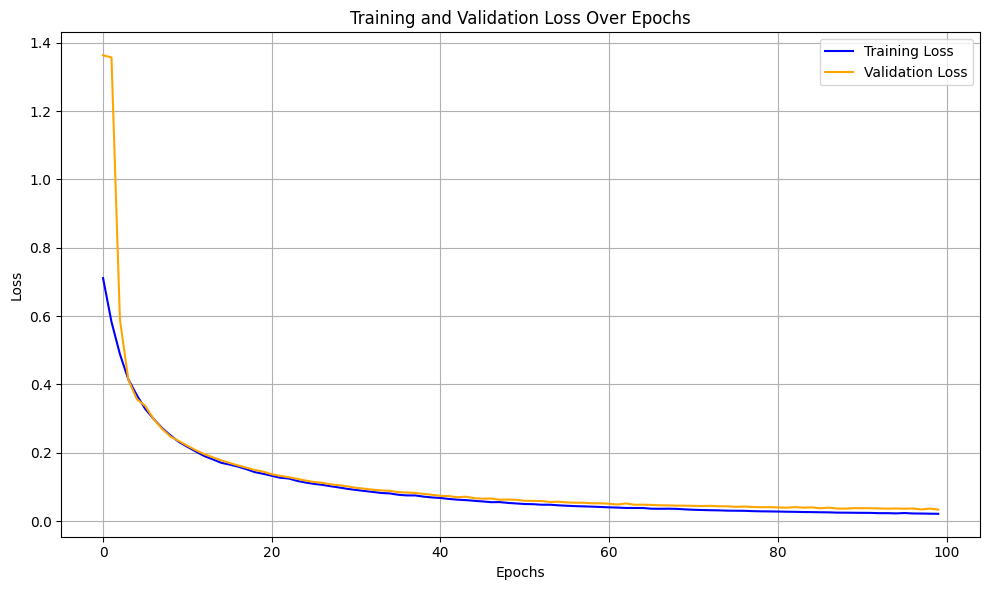

In [13]:
# Plot train and validation loss
train_losses, val_losses = losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### Dice Score

In [14]:
import torch
import numpy as np

def dice_coefficient(preds, labels):
    intersection = np.sum(preds * labels)
    union = np.sum(preds) + np.sum(labels)
    return (2. * intersection) / (union + 1e-7)

In [15]:
model = Unet(encoder_name='resnet18', in_channels=3, classes=2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
checkpoint = torch.load("ResUnet.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calculate Dice coefficient
dice_score = dice_coefficient(np.array(all_preds), np.array(all_labels))
print(f"Overall Dice Coefficient: {dice_score:.4f}")

Overall Dice Coefficient: 0.8218


##### Visualize outputs on test data

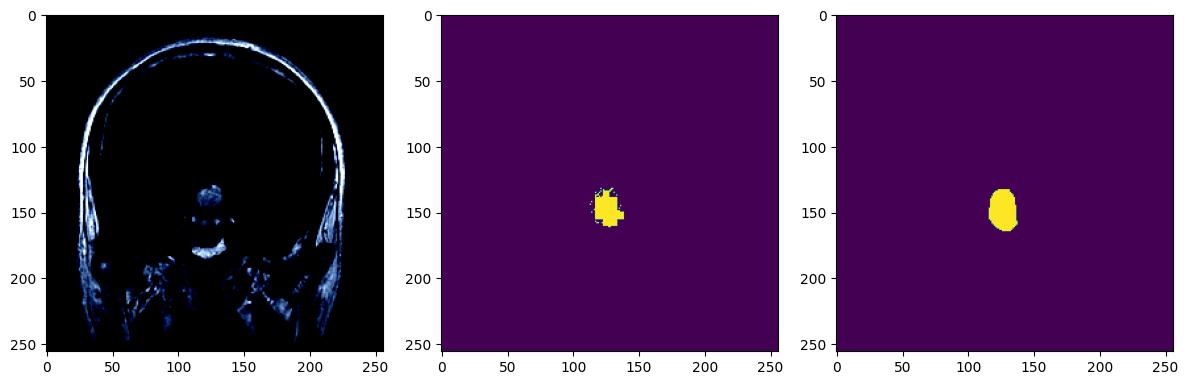

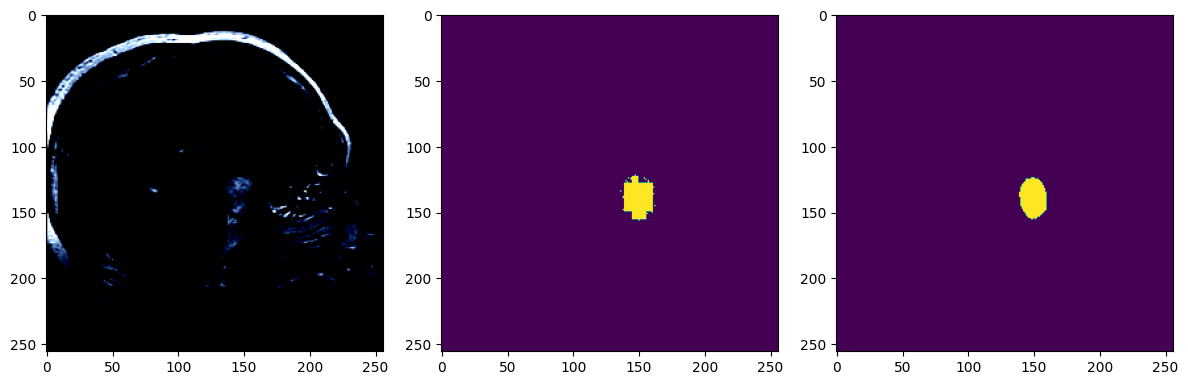

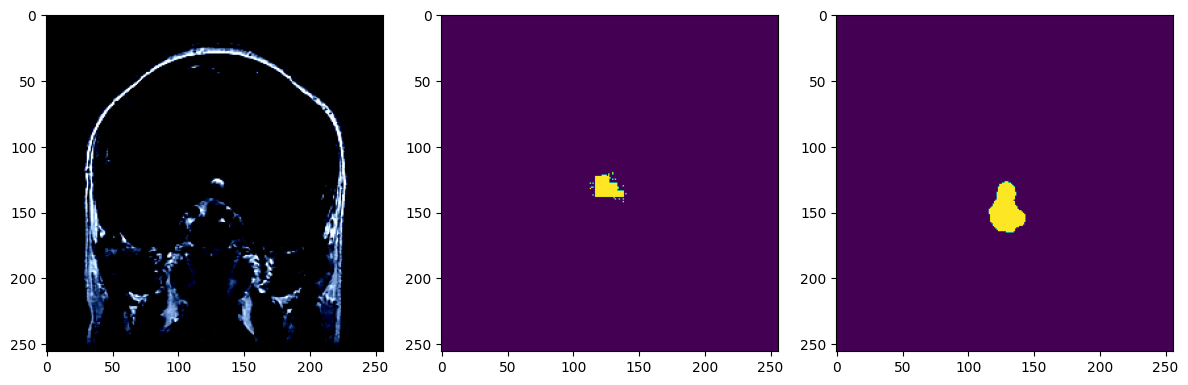

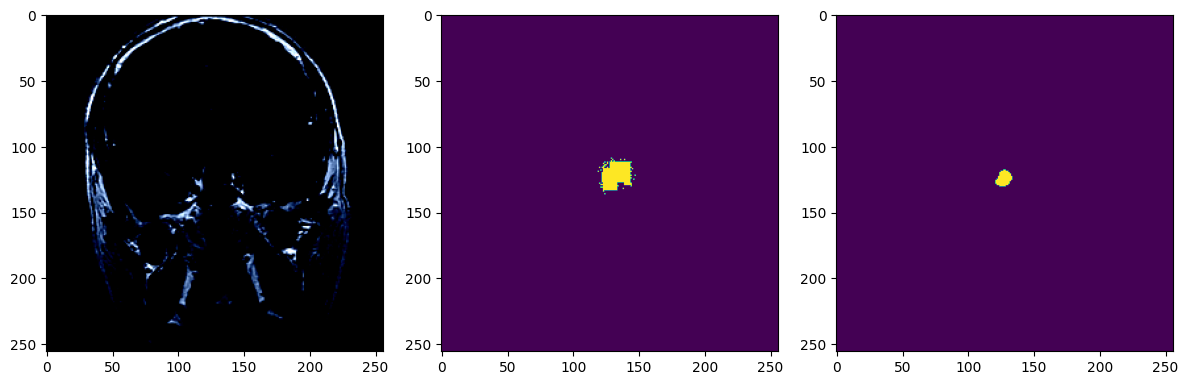

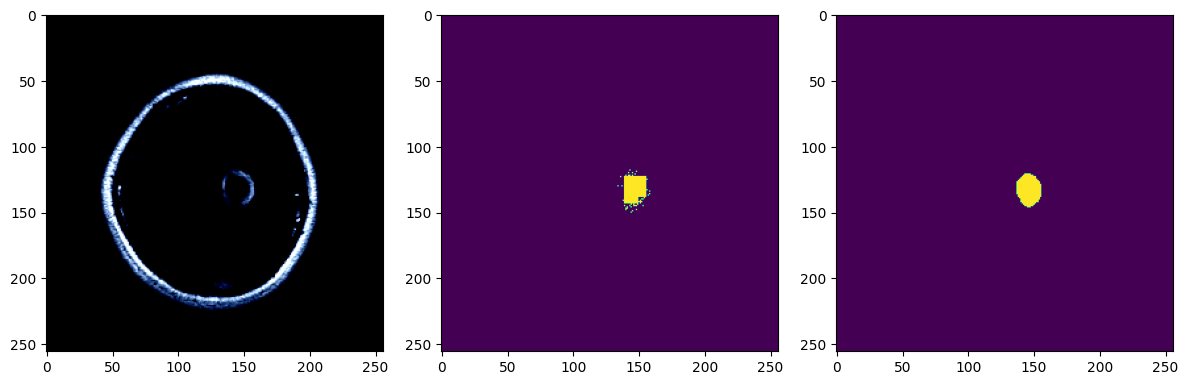

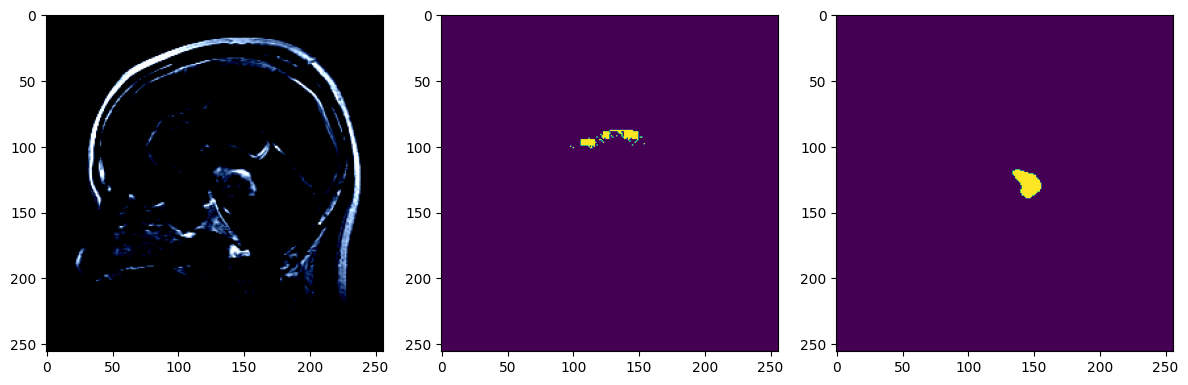

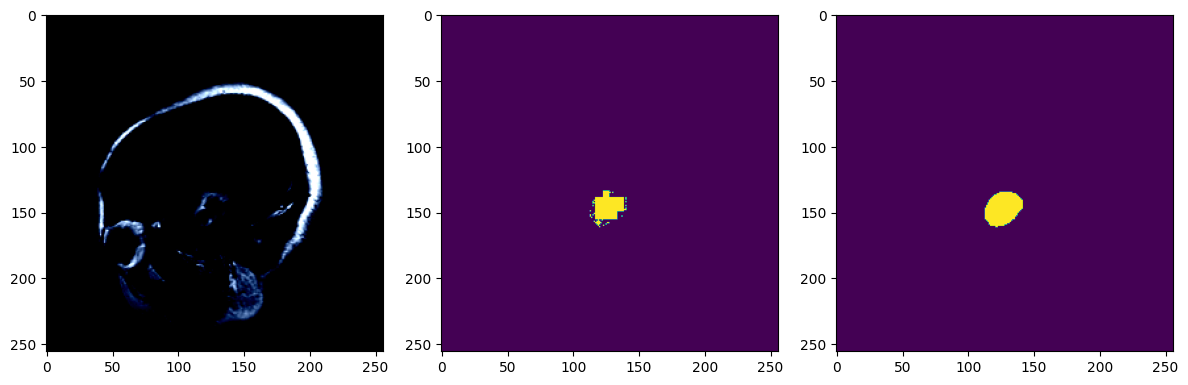

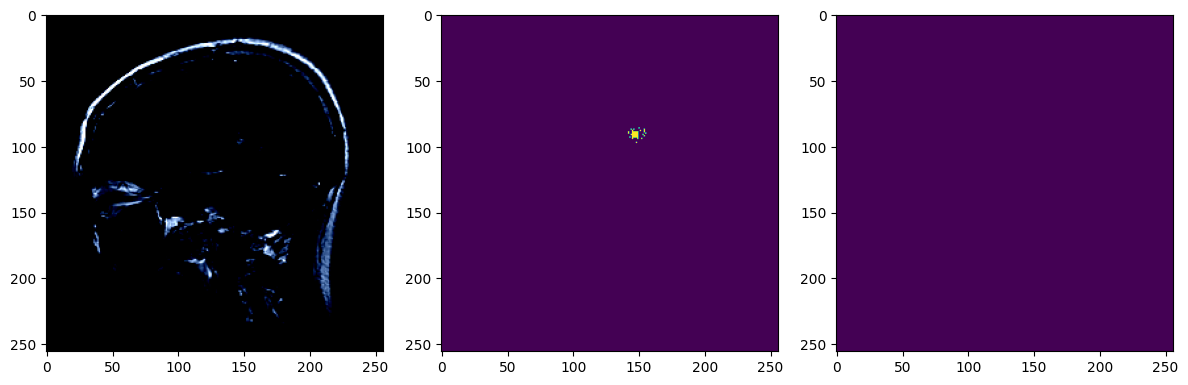

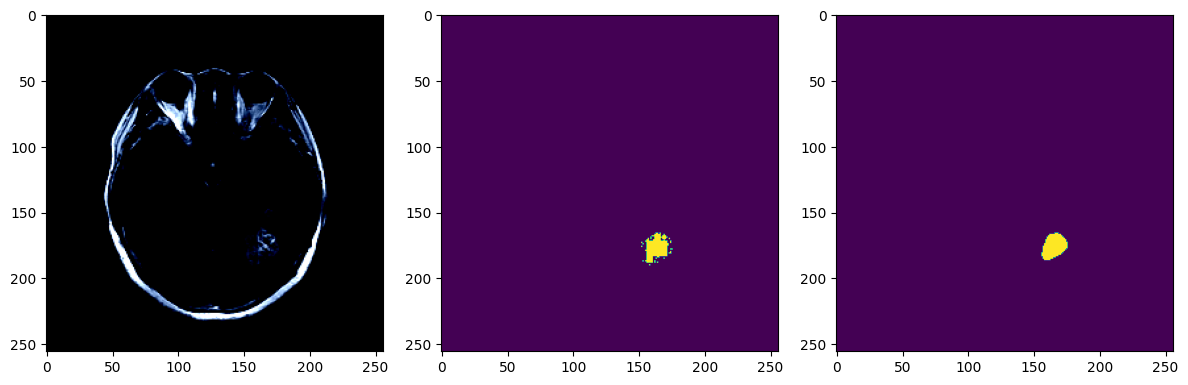

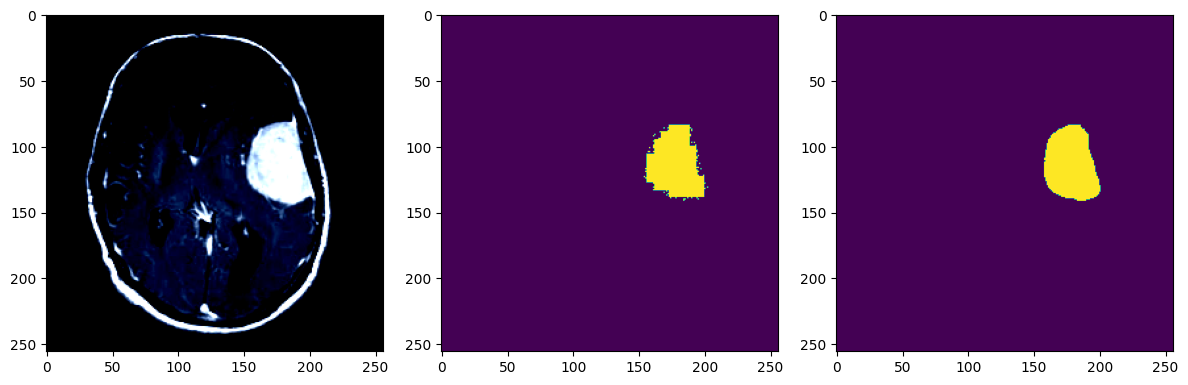

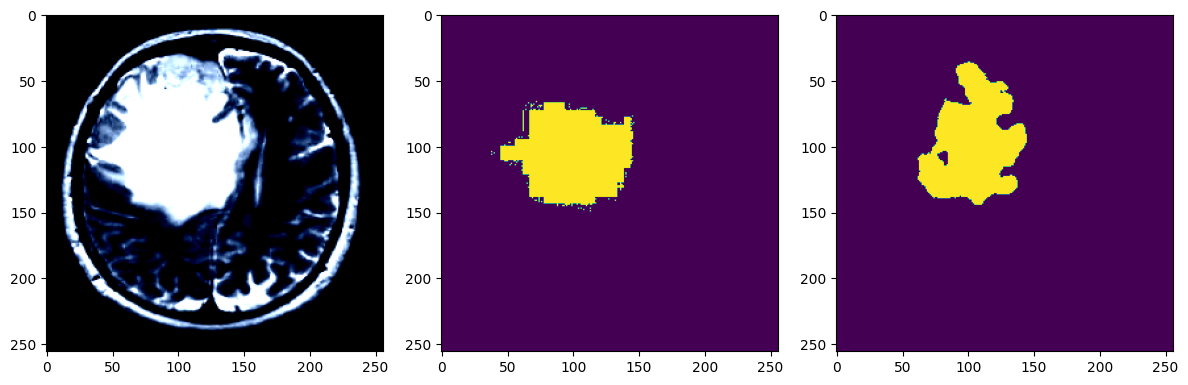

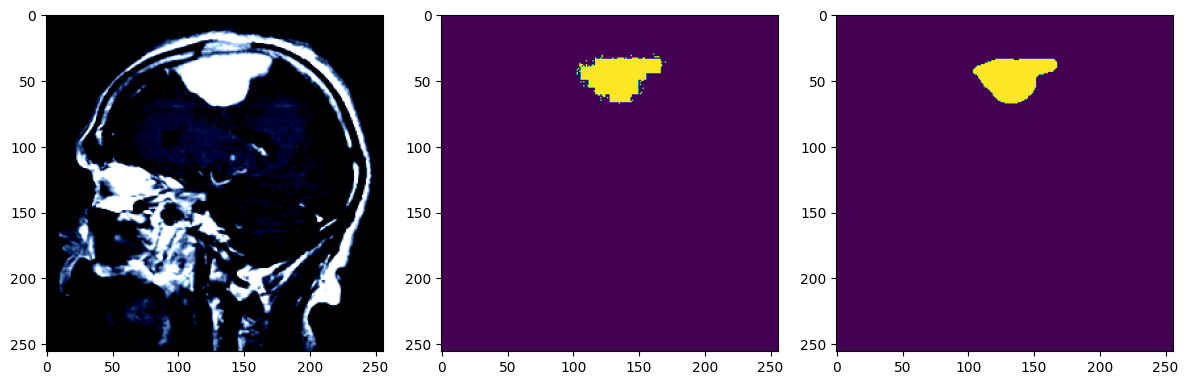

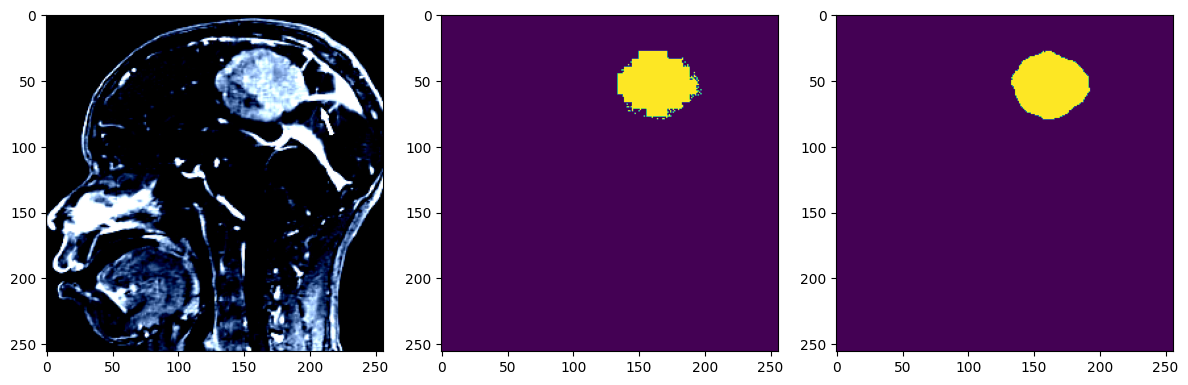

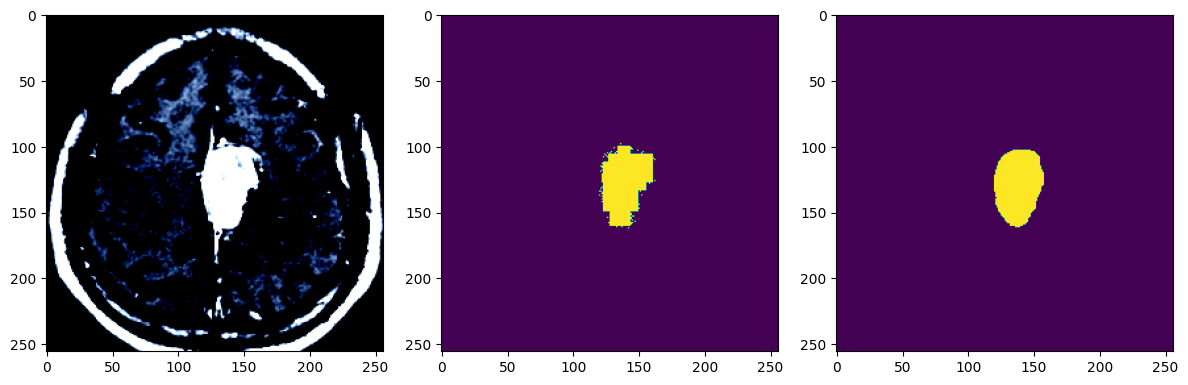

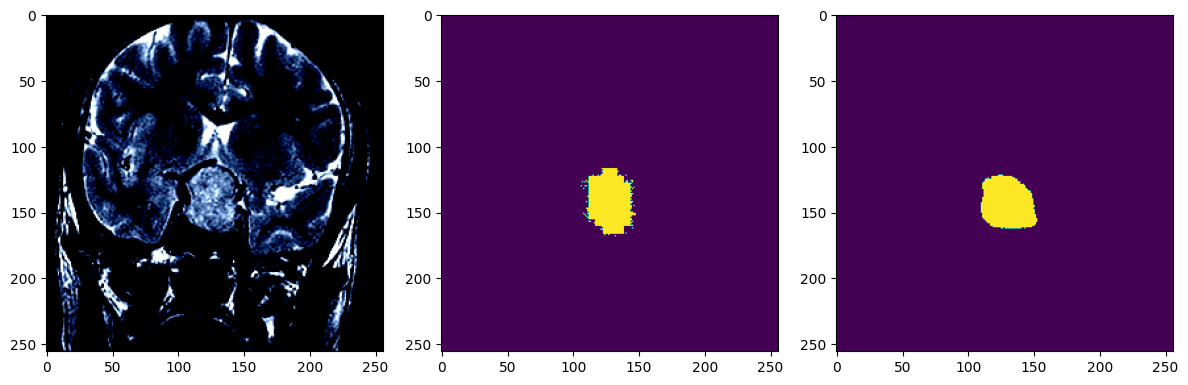

In [16]:
import torch
import numpy as np

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        label = label[0, :, :].cpu().numpy()
        preds = preds[0, :, :].cpu().numpy()
        img = img[0, :, :].cpu().numpy().transpose(1, 2, 0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(img)

        axes[1].imshow(label)

        axes[2].imshow(preds)

        plt.tight_layout()
        plt.show()


## Traing FPN

In [17]:
from segmentation_models_pytorch import FPN

model = FPN(encoder_name='resnet18', in_channels=3, classes=2).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
losses = training(model, train_loader, val_loader, num_epochs, criterion, optimizer, 'FPN.pth')

  1%|          | 1/100 [00:02<04:54,  2.98s/it]

Epoch 1/100, Train Loss: 0.3894839276160513, Validation Loss: 0.15029493138814967


  2%|▏         | 2/100 [00:05<04:27,  2.73s/it]

Epoch 2/100, Train Loss: 0.10052155703306198, Validation Loss: 0.1424999118161698


  3%|▎         | 3/100 [00:08<04:32,  2.81s/it]

Epoch 3/100, Train Loss: 0.07053823556218829, Validation Loss: 0.13272584266960621


  4%|▍         | 4/100 [00:11<04:32,  2.84s/it]

Epoch 4/100, Train Loss: 0.049014484243733544, Validation Loss: 0.1283916231865684


  5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

Epoch 5/100, Train Loss: 0.040839984746915955, Validation Loss: 0.09845147957094014


  6%|▌         | 6/100 [00:16<04:24,  2.81s/it]

Epoch 6/100, Train Loss: 0.035845533811620305, Validation Loss: 0.07941439369072517


  7%|▋         | 7/100 [00:19<04:12,  2.72s/it]

Epoch 7/100, Train Loss: 0.03488653525710106, Validation Loss: 0.08501488701440393


  8%|▊         | 8/100 [00:21<04:04,  2.65s/it]

Epoch 8/100, Train Loss: 0.03319411857851914, Validation Loss: 0.07539639845490456


  9%|▉         | 9/100 [00:24<04:09,  2.74s/it]

Epoch 9/100, Train Loss: 0.030802269599267414, Validation Loss: 0.05862909237233301


 10%|█         | 10/100 [00:27<04:15,  2.84s/it]

Epoch 10/100, Train Loss: 0.028580845466681888, Validation Loss: 0.05621522795408964


 11%|█         | 11/100 [00:30<04:06,  2.76s/it]

Epoch 11/100, Train Loss: 0.024255425802298954, Validation Loss: 0.05734379175119102


 12%|█▏        | 12/100 [00:33<03:57,  2.70s/it]

Epoch 12/100, Train Loss: 0.023685614179287637, Validation Loss: 0.05567164317083855


 13%|█▎        | 13/100 [00:35<03:52,  2.67s/it]

Epoch 13/100, Train Loss: 0.02059479563363961, Validation Loss: 0.05972841459636887


 14%|█▍        | 14/100 [00:38<03:40,  2.56s/it]

Epoch 14/100, Train Loss: 0.020743568960045065, Validation Loss: 0.056232533107201256


 15%|█▌        | 15/100 [00:40<03:40,  2.60s/it]

Epoch 15/100, Train Loss: 0.018405149158622538, Validation Loss: 0.051306381650889916


 16%|█▌        | 16/100 [00:43<03:36,  2.58s/it]

Epoch 16/100, Train Loss: 0.020757642441562245, Validation Loss: 0.0515714621792237


 17%|█▋        | 17/100 [00:45<03:24,  2.46s/it]

Epoch 17/100, Train Loss: 0.020665897322552546, Validation Loss: 0.054471170995384455


 18%|█▊        | 18/100 [00:47<03:15,  2.38s/it]

Epoch 18/100, Train Loss: 0.01698752572493894, Validation Loss: 0.05656931271466116


 19%|█▉        | 19/100 [00:49<03:09,  2.34s/it]

Epoch 19/100, Train Loss: 0.01947218698582479, Validation Loss: 0.053609760214264196


 20%|██        | 20/100 [00:52<03:18,  2.48s/it]

Epoch 20/100, Train Loss: 0.016984794554965838, Validation Loss: 0.04710895023308694


 21%|██        | 21/100 [00:55<03:19,  2.53s/it]

Epoch 21/100, Train Loss: 0.014436513451593263, Validation Loss: 0.05003156503662467


 22%|██▏       | 22/100 [00:57<03:17,  2.54s/it]

Epoch 22/100, Train Loss: 0.0146508678527815, Validation Loss: 0.04585607397990922


 23%|██▎       | 23/100 [01:00<03:23,  2.64s/it]

Epoch 23/100, Train Loss: 0.014941465242632799, Validation Loss: 0.04388392918432752


 24%|██▍       | 24/100 [01:03<03:18,  2.62s/it]

Epoch 24/100, Train Loss: 0.014800819967474257, Validation Loss: 0.04997506615084906


 25%|██▌       | 25/100 [01:05<03:08,  2.51s/it]

Epoch 25/100, Train Loss: 0.014224950623299395, Validation Loss: 0.051146736306448774


 26%|██▌       | 26/100 [01:08<03:05,  2.50s/it]

Epoch 26/100, Train Loss: 0.013617189601063728, Validation Loss: 0.04173165913671255


 27%|██▋       | 27/100 [01:10<03:02,  2.50s/it]

Epoch 27/100, Train Loss: 0.013953699730336666, Validation Loss: 0.0461484470559905


 28%|██▊       | 28/100 [01:12<02:51,  2.38s/it]

Epoch 28/100, Train Loss: 0.014782432998929704, Validation Loss: 0.04509024522267282


 29%|██▉       | 29/100 [01:14<02:43,  2.30s/it]

Epoch 29/100, Train Loss: 0.01262952307505267, Validation Loss: 0.043210754574586945


 30%|███       | 30/100 [01:16<02:39,  2.27s/it]

Epoch 30/100, Train Loss: 0.012799679168633052, Validation Loss: 0.042292778939008714


 31%|███       | 31/100 [01:19<02:36,  2.27s/it]

Epoch 31/100, Train Loss: 0.012539636343717575, Validation Loss: 0.04516385579481721


 32%|███▏      | 32/100 [01:21<02:31,  2.23s/it]

Epoch 32/100, Train Loss: 0.012027450171964509, Validation Loss: 0.04563139787254234


 33%|███▎      | 33/100 [01:23<02:27,  2.20s/it]

Epoch 33/100, Train Loss: 0.012346893016781126, Validation Loss: 0.04552659122273326


 34%|███▍      | 34/100 [01:25<02:24,  2.19s/it]

Epoch 34/100, Train Loss: 0.011837220218564783, Validation Loss: 0.04320482163069149


 35%|███▌      | 35/100 [01:27<02:22,  2.19s/it]

Epoch 35/100, Train Loss: 0.011396259202488832, Validation Loss: 0.043426736692587536


 36%|███▌      | 36/100 [01:30<02:19,  2.19s/it]

Epoch 36/100, Train Loss: 0.014248485277806009, Validation Loss: 0.04173532074006895


 37%|███▋      | 37/100 [01:32<02:25,  2.31s/it]

Epoch 37/100, Train Loss: 0.013910881243646145, Validation Loss: 0.03876494778475414


 38%|███▊      | 38/100 [01:35<02:27,  2.37s/it]

Epoch 38/100, Train Loss: 0.011453253882271903, Validation Loss: 0.044863585165391365


 39%|███▉      | 39/100 [01:37<02:20,  2.30s/it]

Epoch 39/100, Train Loss: 0.010913527304572719, Validation Loss: 0.039482085934529704


 40%|████      | 40/100 [01:39<02:17,  2.29s/it]

Epoch 40/100, Train Loss: 0.011427576786705427, Validation Loss: 0.03912705425173044


 41%|████      | 41/100 [01:41<02:15,  2.30s/it]

Epoch 41/100, Train Loss: 0.011136856329228197, Validation Loss: 0.04233957589603961


 42%|████▏     | 42/100 [01:44<02:12,  2.29s/it]

Epoch 42/100, Train Loss: 0.011007475001471383, Validation Loss: 0.04136125739508619


 43%|████▎     | 43/100 [01:46<02:09,  2.27s/it]

Epoch 43/100, Train Loss: 0.010712935722299985, Validation Loss: 0.0414957563392818


 44%|████▍     | 44/100 [01:48<02:10,  2.33s/it]

Epoch 44/100, Train Loss: 0.010005087059523379, Validation Loss: 0.03790137344039977


 45%|████▌     | 45/100 [01:51<02:18,  2.53s/it]

Epoch 45/100, Train Loss: 0.010597517979996545, Validation Loss: 0.03619971059573193


 46%|████▌     | 46/100 [01:54<02:15,  2.52s/it]

Epoch 46/100, Train Loss: 0.010730449509407793, Validation Loss: 0.03926512693675856


 47%|████▋     | 47/100 [01:56<02:09,  2.44s/it]

Epoch 47/100, Train Loss: 0.010789657144674234, Validation Loss: 0.040243557553427914


 48%|████▊     | 48/100 [01:58<02:04,  2.39s/it]

Epoch 48/100, Train Loss: 0.01021703372576407, Validation Loss: 0.03965893753338605


 49%|████▉     | 49/100 [02:01<02:03,  2.42s/it]

Epoch 49/100, Train Loss: 0.010049049210335528, Validation Loss: 0.03596961713240792


 50%|█████     | 50/100 [02:03<02:02,  2.46s/it]

Epoch 50/100, Train Loss: 0.009705801760511739, Validation Loss: 0.039316976388605936


 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

Epoch 51/100, Train Loss: 0.009670270473829337, Validation Loss: 0.03544392577217271


 52%|█████▏    | 52/100 [02:09<02:05,  2.61s/it]

Epoch 52/100, Train Loss: 0.01008107899022954, Validation Loss: 0.034890718013048175


 53%|█████▎    | 53/100 [02:11<02:02,  2.61s/it]

Epoch 53/100, Train Loss: 0.010336377924042088, Validation Loss: 0.03745587891122947


 54%|█████▍    | 54/100 [02:14<01:53,  2.47s/it]

Epoch 54/100, Train Loss: 0.009799081033893995, Validation Loss: 0.037905597624679405


 55%|█████▌    | 55/100 [02:16<01:51,  2.49s/it]

Epoch 55/100, Train Loss: 0.009509355495018619, Validation Loss: 0.03488773937957982


 56%|█████▌    | 56/100 [02:19<01:49,  2.49s/it]

Epoch 56/100, Train Loss: 0.009164074103214912, Validation Loss: 0.038261369646837316


 57%|█████▋    | 57/100 [02:21<01:43,  2.40s/it]

Epoch 57/100, Train Loss: 0.008973198078040565, Validation Loss: 0.039802744953582686


 58%|█████▊    | 58/100 [02:23<01:38,  2.35s/it]

Epoch 58/100, Train Loss: 0.009119542980832713, Validation Loss: 0.03638651892542839


 59%|█████▉    | 59/100 [02:26<01:37,  2.38s/it]

Epoch 59/100, Train Loss: 0.008877595221357686, Validation Loss: 0.033592782464499274


 60%|██████    | 60/100 [02:28<01:37,  2.43s/it]

Epoch 60/100, Train Loss: 0.009174065265272344, Validation Loss: 0.03887668459986647


 61%|██████    | 61/100 [02:30<01:31,  2.35s/it]

Epoch 61/100, Train Loss: 0.008914665718163763, Validation Loss: 0.035852198985715705


 62%|██████▏   | 62/100 [02:32<01:27,  2.30s/it]

Epoch 62/100, Train Loss: 0.008869379027081388, Validation Loss: 0.03616805817000568


 63%|██████▎   | 63/100 [02:35<01:24,  2.29s/it]

Epoch 63/100, Train Loss: 0.008675698124404465, Validation Loss: 0.03635469159732262


 64%|██████▍   | 64/100 [02:37<01:21,  2.27s/it]

Epoch 64/100, Train Loss: 0.00873710454574653, Validation Loss: 0.03598690120658527


 65%|██████▌   | 65/100 [02:39<01:18,  2.24s/it]

Epoch 65/100, Train Loss: 0.008862469944038562, Validation Loss: 0.03641929069223503


 66%|██████▌   | 66/100 [02:41<01:15,  2.21s/it]

Epoch 66/100, Train Loss: 0.00851660082116723, Validation Loss: 0.03418157343597462


 67%|██████▋   | 67/100 [02:43<01:12,  2.20s/it]

Epoch 67/100, Train Loss: 0.008330568072519131, Validation Loss: 0.035433950189811485


 68%|██████▊   | 68/100 [02:46<01:09,  2.18s/it]

Epoch 68/100, Train Loss: 0.007900974646742855, Validation Loss: 0.036531095214498537


 69%|██████▉   | 69/100 [02:48<01:07,  2.19s/it]

Epoch 69/100, Train Loss: 0.009107314183243684, Validation Loss: 0.03576243967593958


 70%|███████   | 70/100 [02:50<01:05,  2.20s/it]

Epoch 70/100, Train Loss: 0.008676241218511547, Validation Loss: 0.03506652843207121


 71%|███████   | 71/100 [02:52<01:03,  2.19s/it]

Epoch 71/100, Train Loss: 0.00862817938572594, Validation Loss: 0.03699097998129825


 72%|███████▏  | 72/100 [02:55<01:03,  2.27s/it]

Epoch 72/100, Train Loss: 0.008296841422894172, Validation Loss: 0.03349142748241623


 73%|███████▎  | 73/100 [02:57<01:03,  2.35s/it]

Epoch 73/100, Train Loss: 0.008020650528903519, Validation Loss: 0.0364012487931177


 74%|███████▍  | 74/100 [02:59<00:59,  2.29s/it]

Epoch 74/100, Train Loss: 0.008576580456324987, Validation Loss: 0.035164254748572904


 75%|███████▌  | 75/100 [03:02<00:59,  2.36s/it]

Epoch 75/100, Train Loss: 0.007835872271763427, Validation Loss: 0.03253996748632441


 76%|███████▌  | 76/100 [03:04<00:57,  2.41s/it]

Epoch 76/100, Train Loss: 0.008238352436040128, Validation Loss: 0.038124443008564414


 77%|███████▋  | 77/100 [03:06<00:53,  2.33s/it]

Epoch 77/100, Train Loss: 0.00812626803027732, Validation Loss: 0.03681829149524371


 78%|███████▊  | 78/100 [03:09<00:49,  2.26s/it]

Epoch 78/100, Train Loss: 0.008124985665615116, Validation Loss: 0.03474300168454647


 79%|███████▉  | 79/100 [03:11<00:46,  2.23s/it]

Epoch 79/100, Train Loss: 0.008517466685069459, Validation Loss: 0.03475856852407257


 80%|████████  | 80/100 [03:13<00:44,  2.21s/it]

Epoch 80/100, Train Loss: 0.007763335082147803, Validation Loss: 0.03336810837499797


 81%|████████  | 81/100 [03:15<00:42,  2.23s/it]

Epoch 81/100, Train Loss: 0.008107323532125779, Validation Loss: 0.035032401272716625


 82%|████████▏ | 82/100 [03:17<00:39,  2.20s/it]

Epoch 82/100, Train Loss: 0.008045266515442304, Validation Loss: 0.03487098088953644


 83%|████████▎ | 83/100 [03:19<00:36,  2.17s/it]

Epoch 83/100, Train Loss: 0.008338602525847299, Validation Loss: 0.03435387061132739


 84%|████████▍ | 84/100 [03:21<00:34,  2.15s/it]

Epoch 84/100, Train Loss: 0.007970516769481557, Validation Loss: 0.03348945419614514


 85%|████████▌ | 85/100 [03:24<00:31,  2.13s/it]

Epoch 85/100, Train Loss: 0.00788144620933703, Validation Loss: 0.033399258910988765


 86%|████████▌ | 86/100 [03:26<00:29,  2.14s/it]

Epoch 86/100, Train Loss: 0.008641810222928013, Validation Loss: 0.035004638228565456


 87%|████████▋ | 87/100 [03:28<00:29,  2.27s/it]

Epoch 87/100, Train Loss: 0.007589739481253284, Validation Loss: 0.03136323806829751


 88%|████████▊ | 88/100 [03:31<00:28,  2.35s/it]

Epoch 88/100, Train Loss: 0.0077098641943718705, Validation Loss: 0.03271323702453325


 89%|████████▉ | 89/100 [03:33<00:25,  2.29s/it]

Epoch 89/100, Train Loss: 0.008281303968812739, Validation Loss: 0.033297997604434686


 90%|█████████ | 90/100 [03:36<00:23,  2.39s/it]

Epoch 90/100, Train Loss: 0.007461340499243566, Validation Loss: 0.031361342128366235


 91%|█████████ | 91/100 [03:38<00:21,  2.43s/it]

Epoch 91/100, Train Loss: 0.007458156240837914, Validation Loss: 0.03385937872032325


 92%|█████████▏| 92/100 [03:40<00:18,  2.37s/it]

Epoch 92/100, Train Loss: 0.007759532225983483, Validation Loss: 0.03265474333117405


 93%|█████████▎| 93/100 [03:43<00:16,  2.30s/it]

Epoch 93/100, Train Loss: 0.007459463285548347, Validation Loss: 0.03222883678196619


 94%|█████████▍| 94/100 [03:45<00:13,  2.25s/it]

Epoch 94/100, Train Loss: 0.007842166083199638, Validation Loss: 0.0331992324674502


 95%|█████████▌| 95/100 [03:47<00:11,  2.21s/it]

Epoch 95/100, Train Loss: 0.007413716188498906, Validation Loss: 0.03188705214609702


 96%|█████████▌| 96/100 [03:49<00:08,  2.18s/it]

Epoch 96/100, Train Loss: 0.007766880494143281, Validation Loss: 0.0317218894061322


 97%|█████████▋| 97/100 [03:51<00:06,  2.18s/it]

Epoch 97/100, Train Loss: 0.007884820058409656, Validation Loss: 0.033893635116207105


 98%|█████████▊| 98/100 [03:53<00:04,  2.21s/it]

Epoch 98/100, Train Loss: 0.007264434160398585, Validation Loss: 0.03496796283870936


 99%|█████████▉| 99/100 [03:55<00:02,  2.18s/it]

Epoch 99/100, Train Loss: 0.007368275629622596, Validation Loss: 0.032508952310308814


100%|██████████| 100/100 [03:58<00:00,  2.38s/it]

Epoch 100/100, Train Loss: 0.0074269249370055536, Validation Loss: 0.03574975867910932
Epoch 90, Minimum Validation Loss: 0.031361342128366235


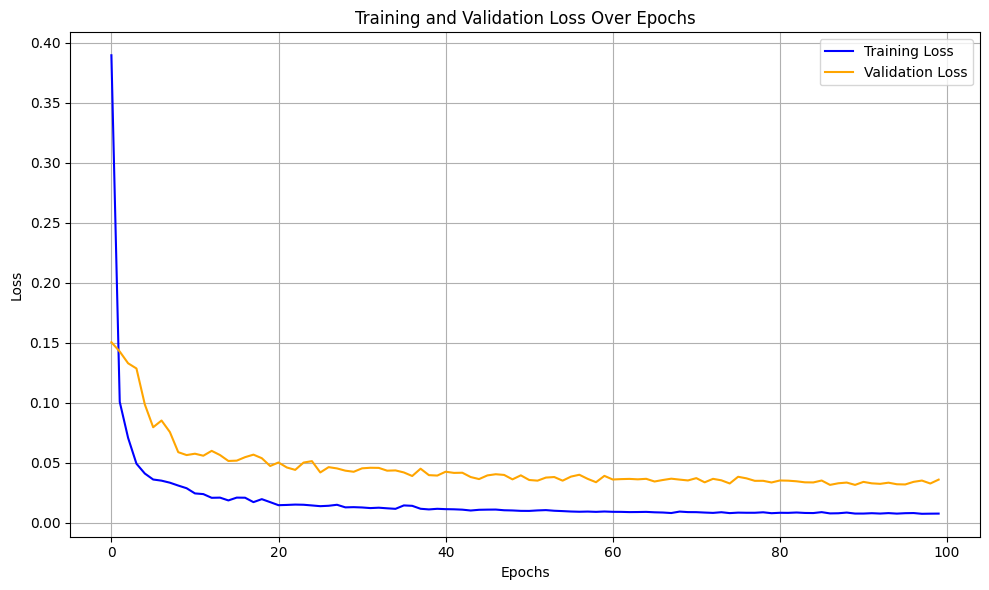

In [18]:
train_losses, val_losses = losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
model = FPN(encoder_name='resnet18', in_channels=3, classes=2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
checkpoint = torch.load("FPN.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calculate Dice coefficient
dice_score = dice_coefficient(np.array(all_preds), np.array(all_labels))
print(f"Overall Dice Coefficient: {dice_score:.4f}")

Overall Dice Coefficient: 0.7299


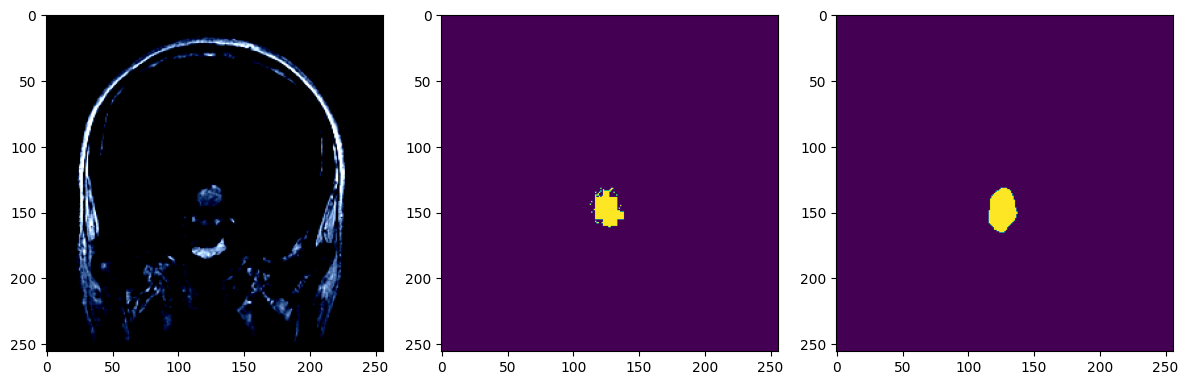

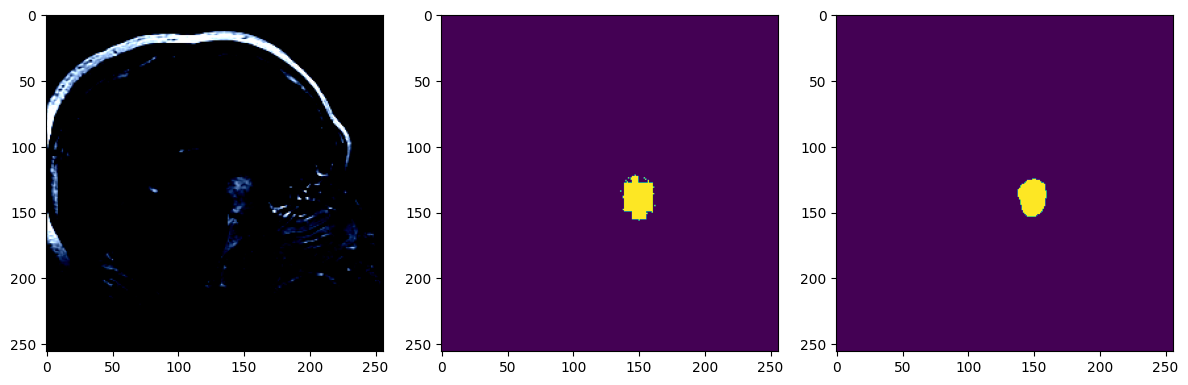

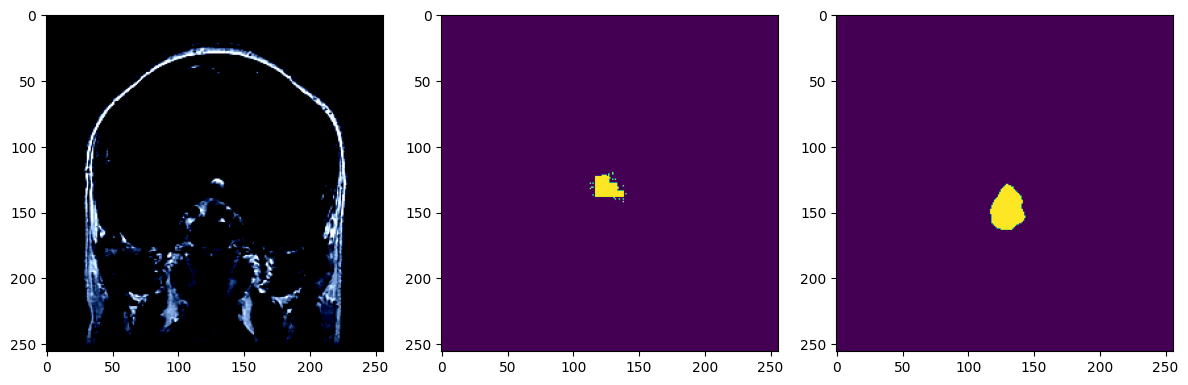

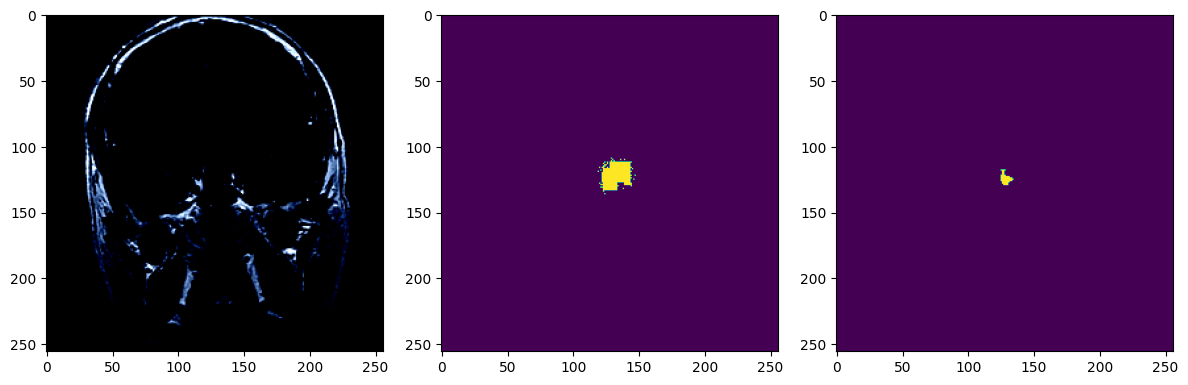

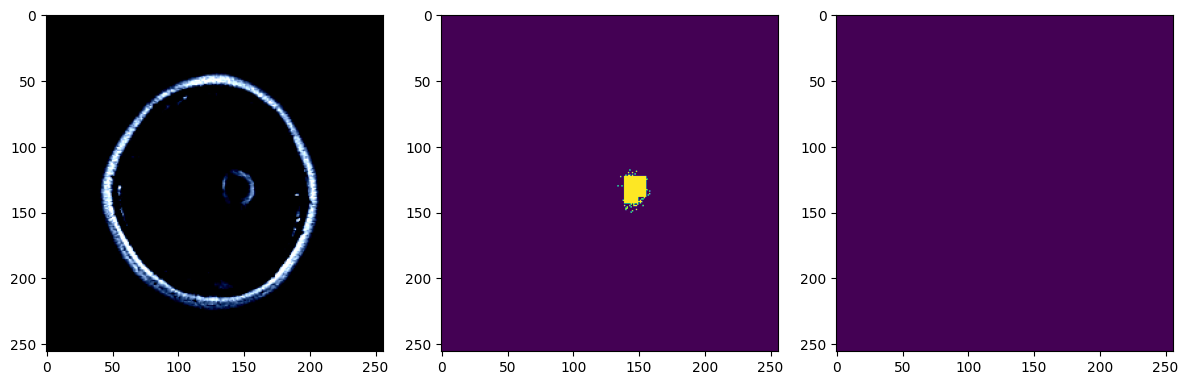

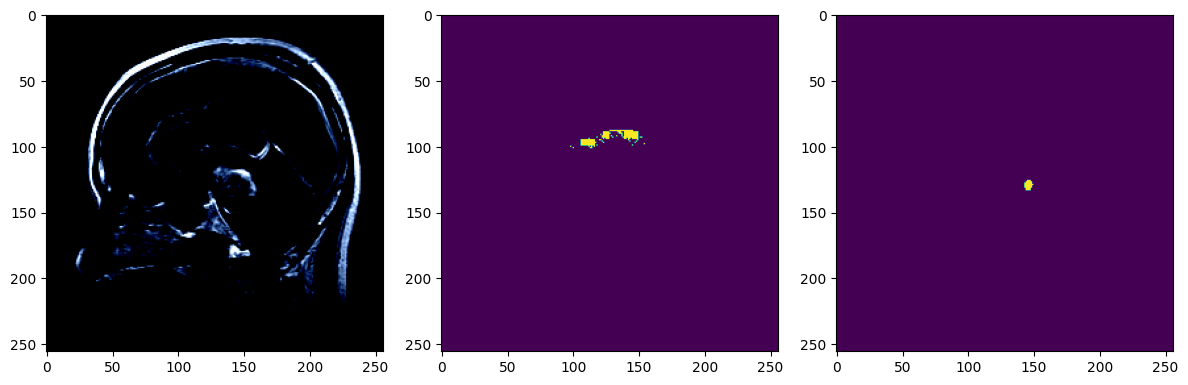

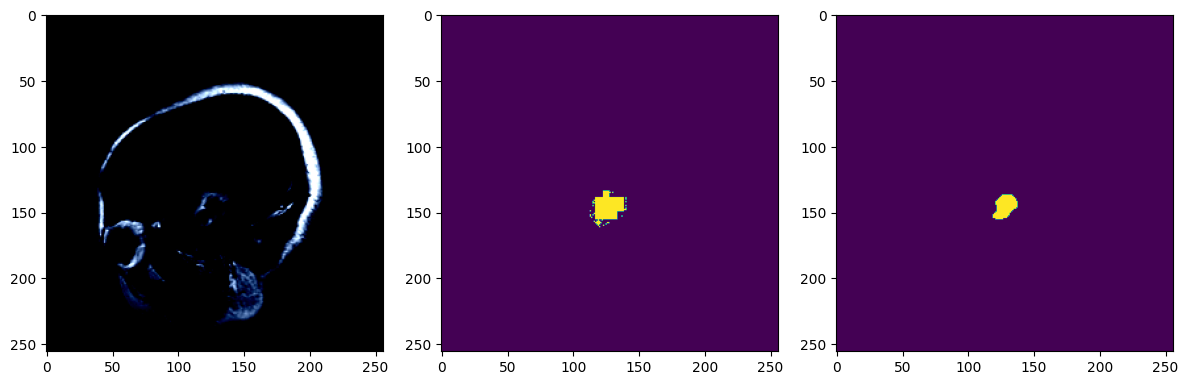

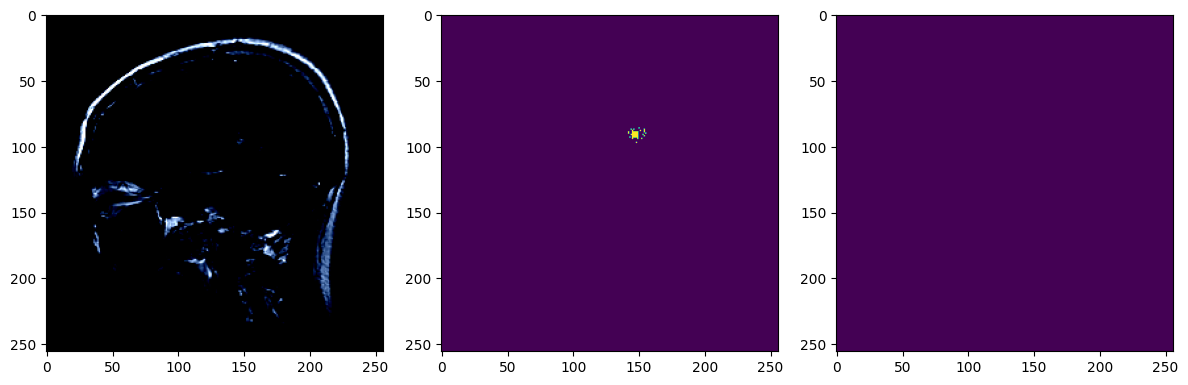

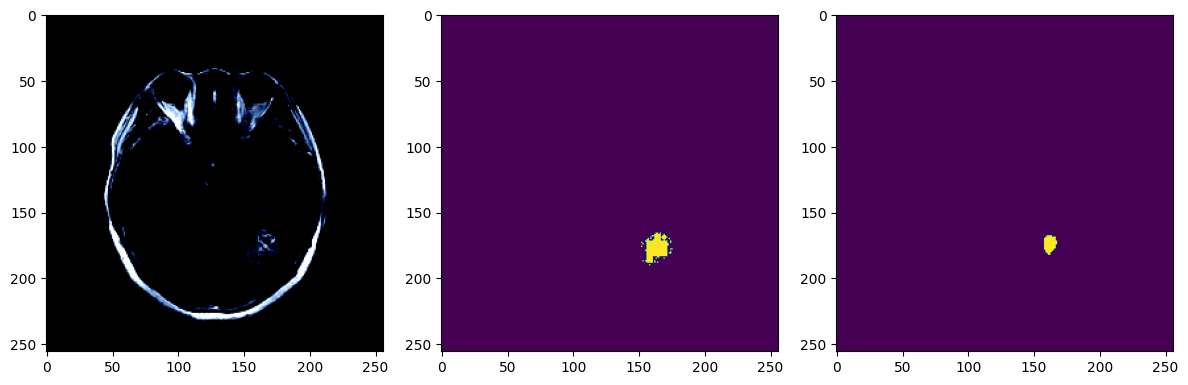

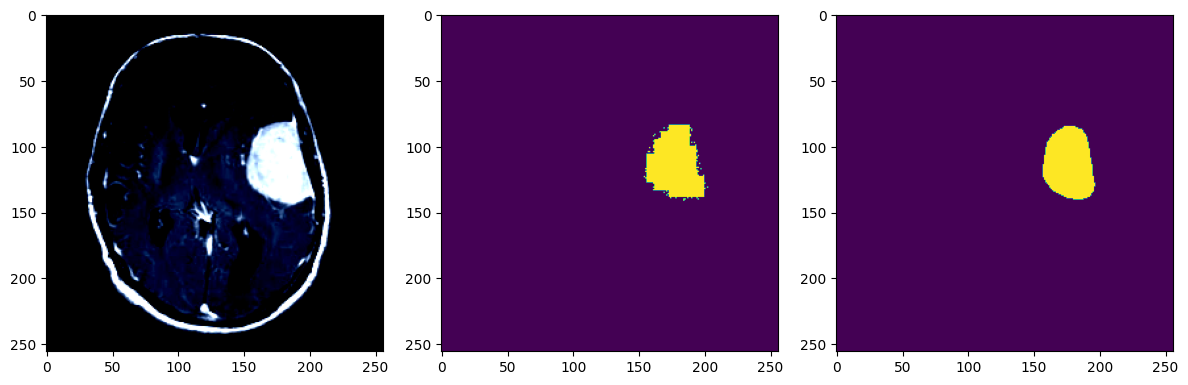

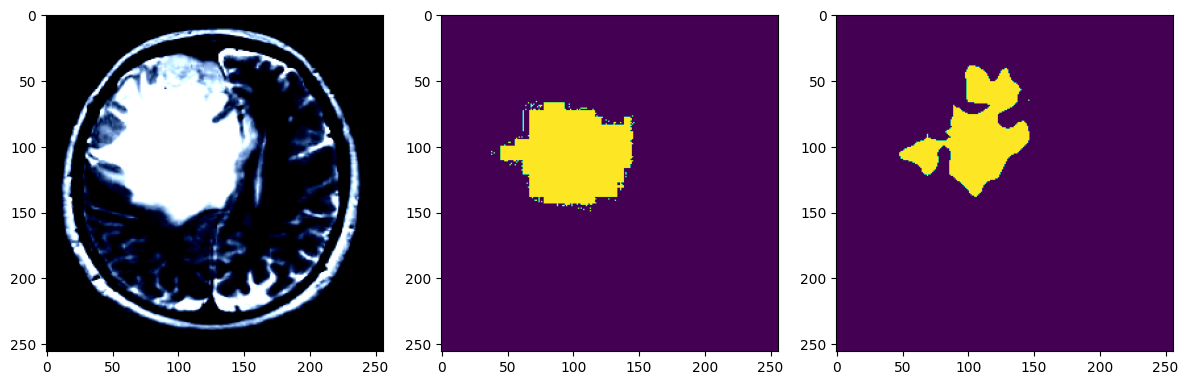

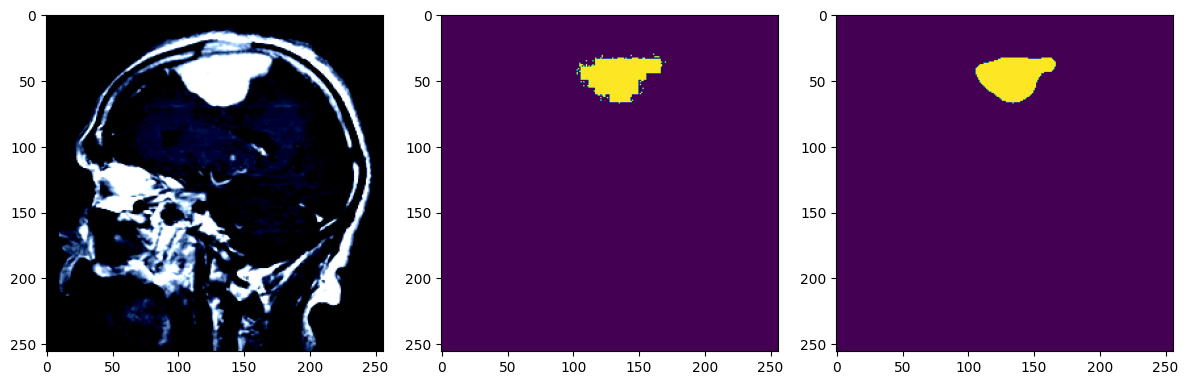

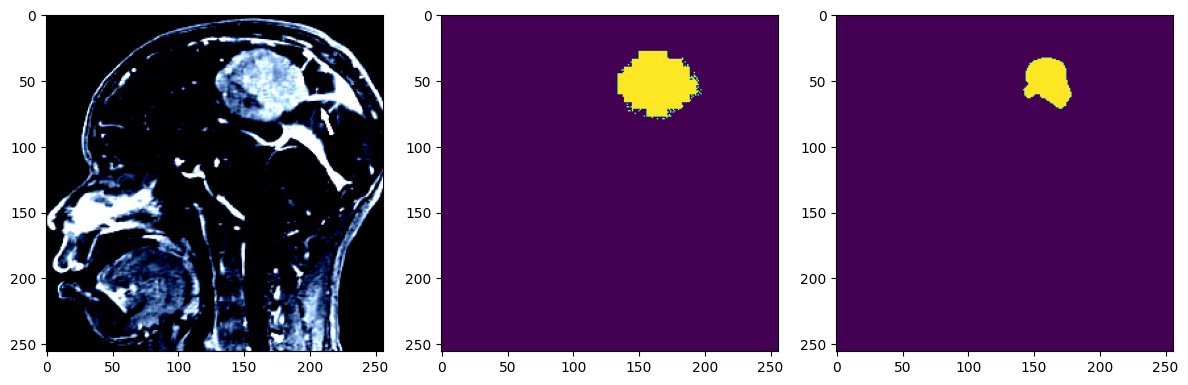

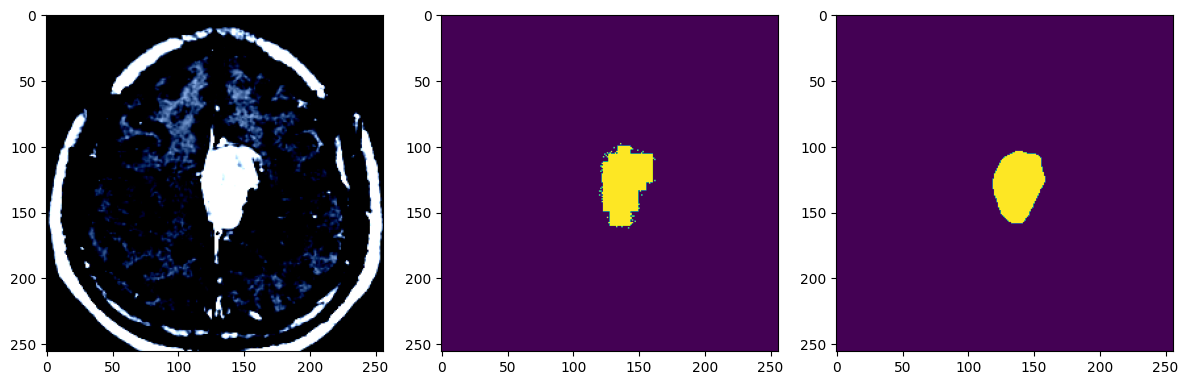

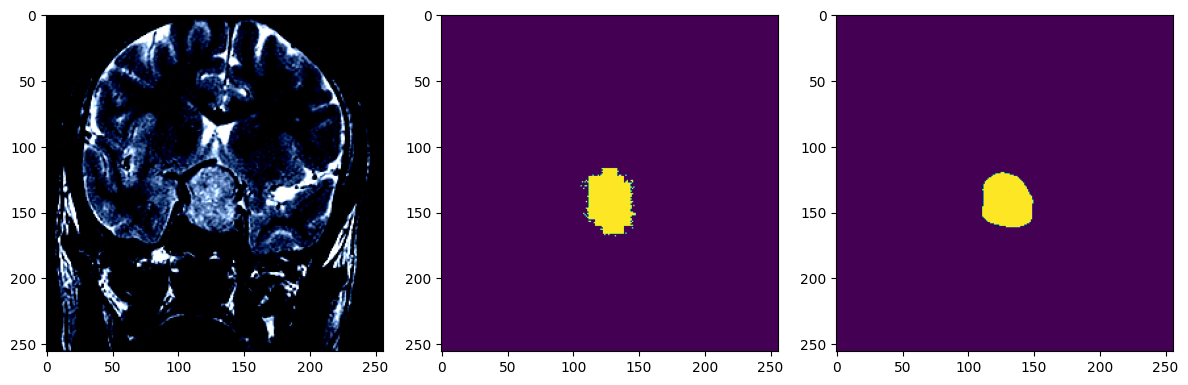

In [20]:
import torch
import numpy as np

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        label = label[0, :, :].cpu().numpy()
        preds = preds[0, :, :].cpu().numpy()
        img = img[0, :, :].cpu().numpy().transpose(1, 2, 0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(img)

        axes[1].imshow(label)

        axes[2].imshow(preds)

        plt.tight_layout()
        plt.show()

## Training PSPNet

In [21]:
from segmentation_models_pytorch import PSPNet

model = PSPNet(encoder_name='resnet18', in_channels=3, classes=2).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
losses = training(model, train_loader, val_loader, num_epochs, criterion, optimizer, 'PSPNet.pth')

  1%|          | 1/100 [00:02<04:01,  2.44s/it]

Epoch 1/100, Train Loss: 0.17483880051544734, Validation Loss: 0.25080556720495223


  2%|▏         | 2/100 [00:04<03:40,  2.25s/it]

Epoch 2/100, Train Loss: 0.07806005754641124, Validation Loss: 0.13959604253371558


  3%|▎         | 3/100 [00:06<03:35,  2.22s/it]

Epoch 3/100, Train Loss: 0.06553477900368827, Validation Loss: 0.09763693896432718


  4%|▍         | 4/100 [00:08<03:32,  2.21s/it]

Epoch 4/100, Train Loss: 0.06033153086900711, Validation Loss: 0.08056100942194462


  5%|▌         | 5/100 [00:11<03:31,  2.23s/it]

Epoch 5/100, Train Loss: 0.04989965632557869, Validation Loss: 0.07082057856023312


  6%|▌         | 6/100 [00:13<03:31,  2.25s/it]

Epoch 6/100, Train Loss: 0.045255022921732495, Validation Loss: 0.06228520491470893


  7%|▋         | 7/100 [00:15<03:28,  2.24s/it]

Epoch 7/100, Train Loss: 0.04158679981316839, Validation Loss: 0.05482541515181462


  8%|▊         | 8/100 [00:17<03:24,  2.22s/it]

Epoch 8/100, Train Loss: 0.03742852195033005, Validation Loss: 0.052046188556899624


  9%|▉         | 9/100 [00:20<03:19,  2.19s/it]

Epoch 9/100, Train Loss: 0.03337309456297329, Validation Loss: 0.05266588435818752


 10%|█         | 10/100 [00:22<03:11,  2.13s/it]

Epoch 10/100, Train Loss: 0.03295841706650598, Validation Loss: 0.05668035189931591


 11%|█         | 11/100 [00:24<03:10,  2.14s/it]

Epoch 11/100, Train Loss: 0.032781933301261494, Validation Loss: 0.0511722029807667


 12%|█▏        | 12/100 [00:26<03:13,  2.20s/it]

Epoch 12/100, Train Loss: 0.02820546685584954, Validation Loss: 0.04640766270458698


 13%|█▎        | 13/100 [00:28<03:07,  2.16s/it]

Epoch 13/100, Train Loss: 0.02614637411066464, Validation Loss: 0.04761063766976197


 14%|█▍        | 14/100 [00:30<03:04,  2.14s/it]

Epoch 14/100, Train Loss: 0.025720408984592984, Validation Loss: 0.04447641242295504


 15%|█▌        | 15/100 [00:32<03:03,  2.16s/it]

Epoch 15/100, Train Loss: 0.025278782738106593, Validation Loss: 0.04269502918856839


 16%|█▌        | 16/100 [00:35<03:03,  2.18s/it]

Epoch 16/100, Train Loss: 0.02251093435500349, Validation Loss: 0.0425644281009833


 17%|█▋        | 17/100 [00:37<03:03,  2.21s/it]

Epoch 17/100, Train Loss: 0.021674236681844507, Validation Loss: 0.03845202561157445


 18%|█▊        | 18/100 [00:39<03:00,  2.20s/it]

Epoch 18/100, Train Loss: 0.021319602083946978, Validation Loss: 0.038817769521847366


 19%|█▉        | 19/100 [00:41<02:57,  2.19s/it]

Epoch 19/100, Train Loss: 0.019296318292617798, Validation Loss: 0.03821070681636532


 20%|██        | 20/100 [00:43<02:55,  2.19s/it]

Epoch 20/100, Train Loss: 0.01858850528619119, Validation Loss: 0.03723301817663014


 21%|██        | 21/100 [00:46<02:53,  2.20s/it]

Epoch 21/100, Train Loss: 0.018718626217118332, Validation Loss: 0.037062649227057896


 22%|██▏       | 22/100 [00:48<02:48,  2.16s/it]

Epoch 22/100, Train Loss: 0.018863058782049587, Validation Loss: 0.0373476954177022


 23%|██▎       | 23/100 [00:50<02:46,  2.17s/it]

Epoch 23/100, Train Loss: 0.01658658084592649, Validation Loss: 0.03467117981053889


 24%|██▍       | 24/100 [00:52<02:45,  2.18s/it]

Epoch 24/100, Train Loss: 0.015813866364104406, Validation Loss: 0.035506503252933426


 25%|██▌       | 25/100 [00:54<02:39,  2.12s/it]

Epoch 25/100, Train Loss: 0.015283023805490561, Validation Loss: 0.03484513107687235


 26%|██▌       | 26/100 [00:56<02:37,  2.13s/it]

Epoch 26/100, Train Loss: 0.0151382124583636, Validation Loss: 0.0338957021633784


 27%|██▋       | 27/100 [00:58<02:34,  2.12s/it]

Epoch 27/100, Train Loss: 0.013940802642277308, Validation Loss: 0.03431073368216554


 28%|██▊       | 28/100 [01:00<02:30,  2.09s/it]

Epoch 28/100, Train Loss: 0.014129753224551678, Validation Loss: 0.037688999871412915


 29%|██▉       | 29/100 [01:02<02:27,  2.08s/it]

Epoch 29/100, Train Loss: 0.013579637078302247, Validation Loss: 0.03617478259839117


 30%|███       | 30/100 [01:05<02:29,  2.13s/it]

Epoch 30/100, Train Loss: 0.012809161628995622, Validation Loss: 0.033229176824291544


 31%|███       | 31/100 [01:07<02:25,  2.11s/it]

Epoch 31/100, Train Loss: 0.012886693035917622, Validation Loss: 0.03490426107309759


 32%|███▏      | 32/100 [01:09<02:21,  2.07s/it]

Epoch 32/100, Train Loss: 0.012848886927323682, Validation Loss: 0.03372264701562623


 33%|███▎      | 33/100 [01:11<02:17,  2.05s/it]

Epoch 33/100, Train Loss: 0.01226064788975886, Validation Loss: 0.03516097671041886


 34%|███▍      | 34/100 [01:13<02:14,  2.04s/it]

Epoch 34/100, Train Loss: 0.012233445686953408, Validation Loss: 0.036280531669035554


 35%|███▌      | 35/100 [01:15<02:11,  2.03s/it]

Epoch 35/100, Train Loss: 0.011852280768964971, Validation Loss: 0.03865870959125459


 36%|███▌      | 36/100 [01:17<02:11,  2.05s/it]

Epoch 36/100, Train Loss: 0.011550487950444221, Validation Loss: 0.03558844781170289


 37%|███▋      | 37/100 [01:19<02:11,  2.08s/it]

Epoch 37/100, Train Loss: 0.011813597487551826, Validation Loss: 0.032519828310857216


 38%|███▊      | 38/100 [01:21<02:09,  2.09s/it]

Epoch 38/100, Train Loss: 0.011031630848135267, Validation Loss: 0.035634224272022647


 39%|███▉      | 39/100 [01:23<02:05,  2.05s/it]

Epoch 39/100, Train Loss: 0.01088863704353571, Validation Loss: 0.03471425767056644


 40%|████      | 40/100 [01:25<02:02,  2.05s/it]

Epoch 40/100, Train Loss: 0.010809336655906268, Validation Loss: 0.03736418103799224


 41%|████      | 41/100 [01:27<01:59,  2.03s/it]

Epoch 41/100, Train Loss: 0.01062199819300856, Validation Loss: 0.04091782978114982


 42%|████▏     | 42/100 [01:29<01:58,  2.04s/it]

Epoch 42/100, Train Loss: 0.011098890964473997, Validation Loss: 0.03911836479480068


 43%|████▎     | 43/100 [01:31<01:58,  2.08s/it]

Epoch 43/100, Train Loss: 0.010349334483700139, Validation Loss: 0.03109471034258604


 44%|████▍     | 44/100 [01:33<01:56,  2.08s/it]

Epoch 44/100, Train Loss: 0.010241964033671789, Validation Loss: 0.03458688549386958


 45%|████▌     | 45/100 [01:35<01:53,  2.06s/it]

Epoch 45/100, Train Loss: 0.010423543131245034, Validation Loss: 0.03674540903108815


 46%|████▌     | 46/100 [01:37<01:50,  2.04s/it]

Epoch 46/100, Train Loss: 0.01003419900579112, Validation Loss: 0.03353164913132787


 47%|████▋     | 47/100 [01:39<01:47,  2.02s/it]

Epoch 47/100, Train Loss: 0.009534524421074561, Validation Loss: 0.03772336766123772


 48%|████▊     | 48/100 [01:41<01:45,  2.04s/it]

Epoch 48/100, Train Loss: 0.009608050941356592, Validation Loss: 0.03785384458800157


 49%|████▉     | 49/100 [01:44<01:44,  2.05s/it]

Epoch 49/100, Train Loss: 0.009623723703303508, Validation Loss: 0.034420362176994485


 50%|█████     | 50/100 [01:46<01:41,  2.03s/it]

Epoch 50/100, Train Loss: 0.009597794019750186, Validation Loss: 0.03720411557393769


 51%|█████     | 51/100 [01:48<01:39,  2.02s/it]

Epoch 51/100, Train Loss: 0.009643924222992999, Validation Loss: 0.03734457343816757


 52%|█████▏    | 52/100 [01:50<01:37,  2.03s/it]

Epoch 52/100, Train Loss: 0.009473668078758888, Validation Loss: 0.03289393434921901


 53%|█████▎    | 53/100 [01:52<01:34,  2.02s/it]

Epoch 53/100, Train Loss: 0.009290301640118872, Validation Loss: 0.037985151757796605


 54%|█████▍    | 54/100 [01:54<01:32,  2.01s/it]

Epoch 54/100, Train Loss: 0.008873779459723405, Validation Loss: 0.03554081106558442


 55%|█████▌    | 55/100 [01:56<01:32,  2.05s/it]

Epoch 55/100, Train Loss: 0.00874966855293938, Validation Loss: 0.03443512412098547


 56%|█████▌    | 56/100 [01:58<01:29,  2.04s/it]

Epoch 56/100, Train Loss: 0.008525100403598376, Validation Loss: 0.03661822931220134


 57%|█████▋    | 57/100 [02:00<01:26,  2.02s/it]

Epoch 57/100, Train Loss: 0.008583989526544298, Validation Loss: 0.03748152487290402


 58%|█████▊    | 58/100 [02:02<01:24,  2.01s/it]

Epoch 58/100, Train Loss: 0.008387314155697823, Validation Loss: 0.034272923103223246


 59%|█████▉    | 59/100 [02:04<01:22,  2.00s/it]

Epoch 59/100, Train Loss: 0.008124034120036023, Validation Loss: 0.03667043424211443


 60%|██████    | 60/100 [02:06<01:20,  2.01s/it]

Epoch 60/100, Train Loss: 0.008469289235238518, Validation Loss: 0.036001520790159704


 61%|██████    | 61/100 [02:08<01:18,  2.02s/it]

Epoch 61/100, Train Loss: 0.008208962556506907, Validation Loss: 0.03577450284113486


 62%|██████▏   | 62/100 [02:10<01:17,  2.04s/it]

Epoch 62/100, Train Loss: 0.008943690253155572, Validation Loss: 0.03808431336656213


 63%|██████▎   | 63/100 [02:12<01:15,  2.04s/it]

Epoch 63/100, Train Loss: 0.008168974758258887, Validation Loss: 0.03545321919955313


 64%|██████▍   | 64/100 [02:14<01:14,  2.07s/it]

Epoch 64/100, Train Loss: 0.008258219941386155, Validation Loss: 0.03794612119284769


 65%|██████▌   | 65/100 [02:16<01:11,  2.05s/it]

Epoch 65/100, Train Loss: 0.008103909237044198, Validation Loss: 0.03585040494799614


 66%|██████▌   | 66/100 [02:18<01:09,  2.03s/it]

Epoch 66/100, Train Loss: 0.00780946488625237, Validation Loss: 0.034730903105810285


 67%|██████▋   | 67/100 [02:20<01:07,  2.04s/it]

Epoch 67/100, Train Loss: 0.007850061902510268, Validation Loss: 0.031328667506265145


 68%|██████▊   | 68/100 [02:22<01:06,  2.07s/it]

Epoch 68/100, Train Loss: 0.008690510876476765, Validation Loss: 0.034095739899203184


 69%|██████▉   | 69/100 [02:24<01:03,  2.05s/it]

Epoch 69/100, Train Loss: 0.00780343244384442, Validation Loss: 0.038747777914007506


 70%|███████   | 70/100 [02:26<01:01,  2.03s/it]

Epoch 70/100, Train Loss: 0.007735072369022029, Validation Loss: 0.03911749077960849


 71%|███████   | 71/100 [02:28<00:58,  2.02s/it]

Epoch 71/100, Train Loss: 0.007839496846177749, Validation Loss: 0.031521064896757406


 72%|███████▏  | 72/100 [02:30<00:56,  2.01s/it]

Epoch 72/100, Train Loss: 0.00781383937490838, Validation Loss: 0.034289605682715774


 73%|███████▎  | 73/100 [02:32<00:54,  2.00s/it]

Epoch 73/100, Train Loss: 0.007513073938233512, Validation Loss: 0.04051868310198188


 74%|███████▍  | 74/100 [02:34<00:53,  2.04s/it]

Epoch 74/100, Train Loss: 0.007620484634701695, Validation Loss: 0.03493872773833573


 75%|███████▌  | 75/100 [02:36<00:51,  2.04s/it]

Epoch 75/100, Train Loss: 0.007491459005645343, Validation Loss: 0.03137988911475986


 76%|███████▌  | 76/100 [02:38<00:48,  2.03s/it]

Epoch 76/100, Train Loss: 0.007725907689226525, Validation Loss: 0.03900802480056882


 77%|███████▋  | 77/100 [02:40<00:46,  2.02s/it]

Epoch 77/100, Train Loss: 0.007211199895079646, Validation Loss: 0.04397248360328376


 78%|███████▊  | 78/100 [02:42<00:44,  2.01s/it]

Epoch 78/100, Train Loss: 0.0074282582583171984, Validation Loss: 0.03982330531192323


 79%|███████▉  | 79/100 [02:44<00:42,  2.00s/it]

Epoch 79/100, Train Loss: 0.007352054185633149, Validation Loss: 0.036609148560091856


 80%|████████  | 80/100 [02:46<00:40,  2.01s/it]

Epoch 80/100, Train Loss: 0.007277038014893021, Validation Loss: 0.0359212668457379


 81%|████████  | 81/100 [02:48<00:38,  2.04s/it]

Epoch 81/100, Train Loss: 0.007287909609398672, Validation Loss: 0.035507417656481265


 82%|████████▏ | 82/100 [02:50<00:36,  2.04s/it]

Epoch 82/100, Train Loss: 0.007216222118586302, Validation Loss: 0.035017344557369746


 83%|████████▎ | 83/100 [02:52<00:34,  2.02s/it]

Epoch 83/100, Train Loss: 0.007353533192404679, Validation Loss: 0.037329188315197825


 84%|████████▍ | 84/100 [02:54<00:32,  2.01s/it]

Epoch 84/100, Train Loss: 0.007098489374454532, Validation Loss: 0.03483379757963121


 85%|████████▌ | 85/100 [02:56<00:29,  1.99s/it]

Epoch 85/100, Train Loss: 0.0075402276457420415, Validation Loss: 0.03781321517502268


 86%|████████▌ | 86/100 [02:58<00:28,  2.01s/it]

Epoch 86/100, Train Loss: 0.007725532565798078, Validation Loss: 0.04386183158494532


 87%|████████▋ | 87/100 [03:01<00:26,  2.05s/it]

Epoch 87/100, Train Loss: 0.007380821875163487, Validation Loss: 0.03323206244967878


 88%|████████▊ | 88/100 [03:03<00:24,  2.05s/it]

Epoch 88/100, Train Loss: 0.007327062410435506, Validation Loss: 0.031128438445739447


 89%|████████▉ | 89/100 [03:05<00:22,  2.04s/it]

Epoch 89/100, Train Loss: 0.007440419801111732, Validation Loss: 0.03805036523068945


 90%|█████████ | 90/100 [03:07<00:20,  2.02s/it]

Epoch 90/100, Train Loss: 0.007381455706698554, Validation Loss: 0.039402344295134145


 91%|█████████ | 91/100 [03:09<00:17,  2.00s/it]

Epoch 91/100, Train Loss: 0.007263317571154663, Validation Loss: 0.036560842751835784


 92%|█████████▏| 92/100 [03:11<00:15,  1.99s/it]

Epoch 92/100, Train Loss: 0.006910242872046573, Validation Loss: 0.03914820097076396


 93%|█████████▎| 93/100 [03:13<00:14,  2.02s/it]

Epoch 93/100, Train Loss: 0.007619801443070173, Validation Loss: 0.032804595430692036


 94%|█████████▍| 94/100 [03:15<00:12,  2.06s/it]

Epoch 94/100, Train Loss: 0.007131164494369712, Validation Loss: 0.029676455344694357


 95%|█████████▌| 95/100 [03:17<00:10,  2.07s/it]

Epoch 95/100, Train Loss: 0.007135157007724047, Validation Loss: 0.04070966886356473


 96%|█████████▌| 96/100 [03:19<00:08,  2.04s/it]

Epoch 96/100, Train Loss: 0.006773385485368115, Validation Loss: 0.03791455769290527


 97%|█████████▋| 97/100 [03:21<00:06,  2.02s/it]

Epoch 97/100, Train Loss: 0.006864139078451055, Validation Loss: 0.0376957846339792


 98%|█████████▊| 98/100 [03:23<00:04,  2.01s/it]

Epoch 98/100, Train Loss: 0.006938104251665729, Validation Loss: 0.03911565000501772


 99%|█████████▉| 99/100 [03:25<00:02,  2.02s/it]

Epoch 99/100, Train Loss: 0.006912942510098219, Validation Loss: 0.037304207868874076


100%|██████████| 100/100 [03:27<00:00,  2.07s/it]

Epoch 100/100, Train Loss: 0.006649556436708995, Validation Loss: 0.037009594046200314
Epoch 94, Minimum Validation Loss: 0.029676455344694357


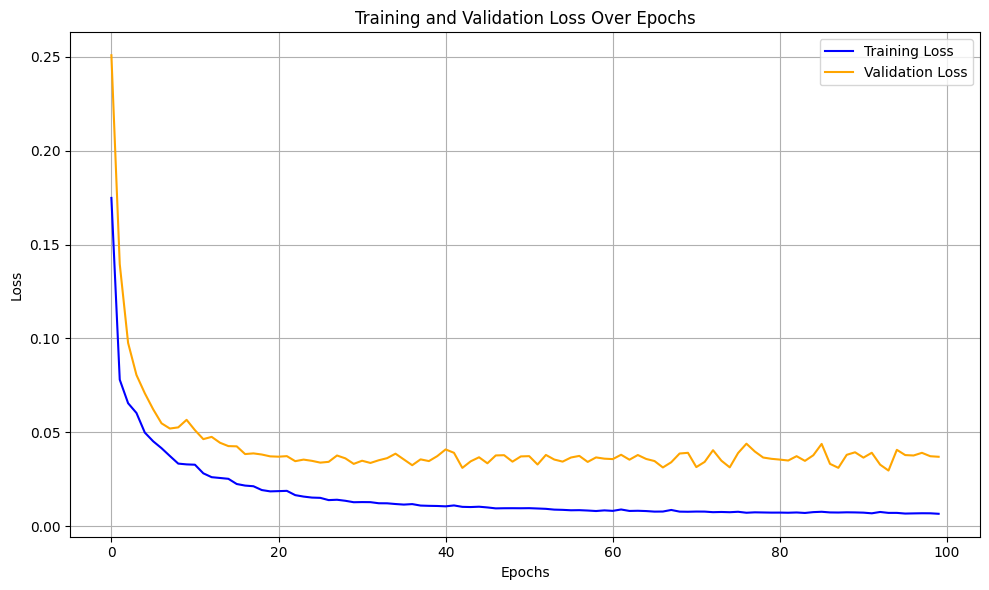

In [22]:
train_losses, val_losses = losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
model = PSPNet(encoder_name='resnet18', in_channels=3, classes=2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
checkpoint = torch.load("PSPNet.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calculate Dice coefficient
dice_score = dice_coefficient(np.array(all_preds), np.array(all_labels))
print(f"Overall Dice Coefficient: {dice_score:.4f}")

Overall Dice Coefficient: 0.7969


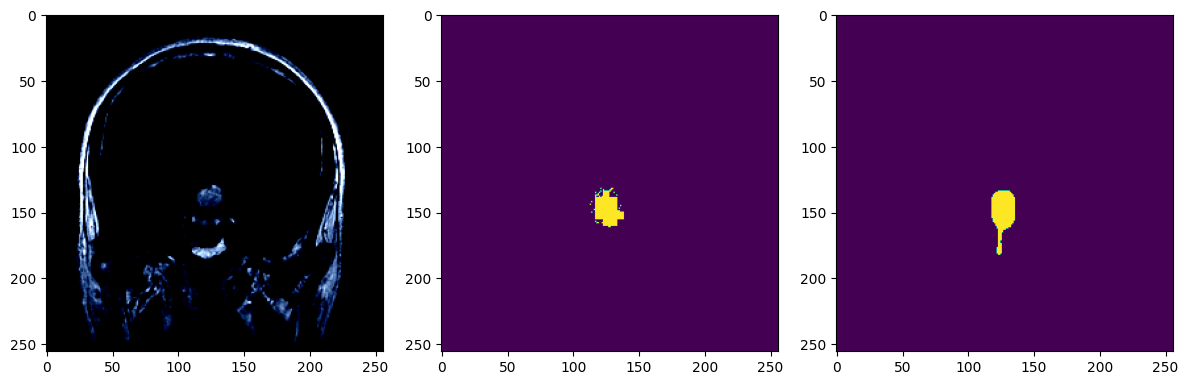

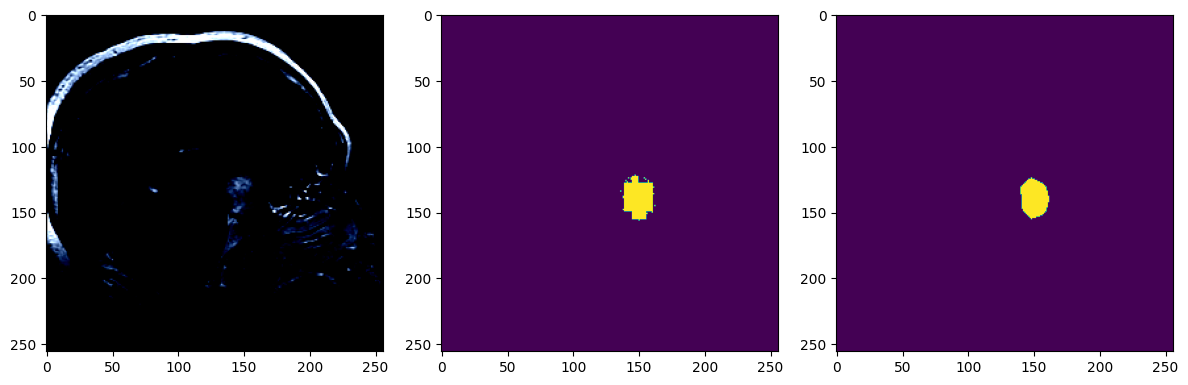

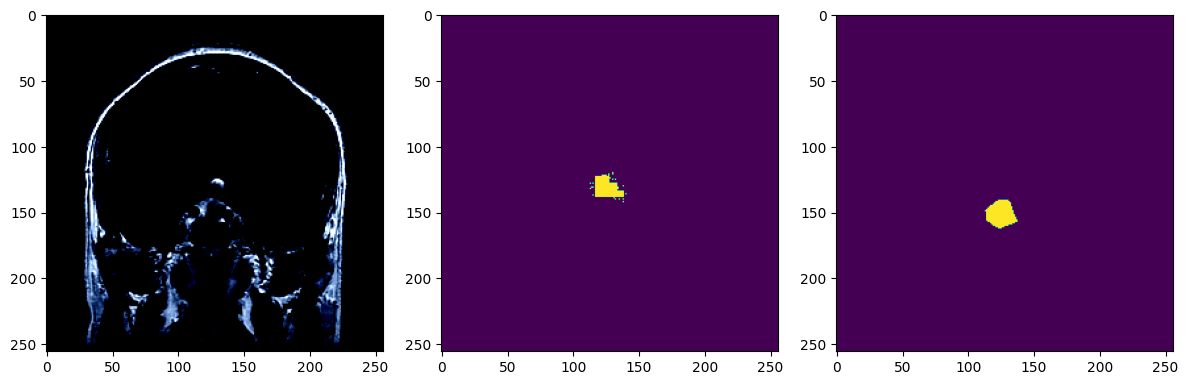

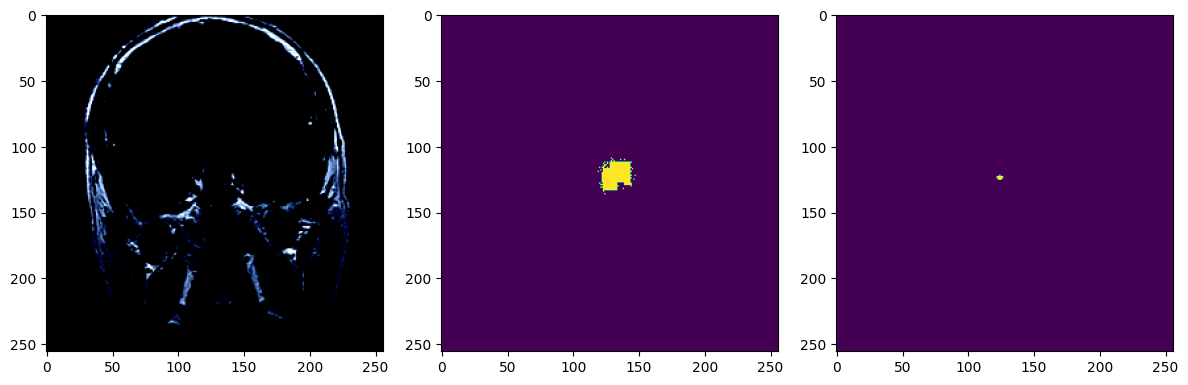

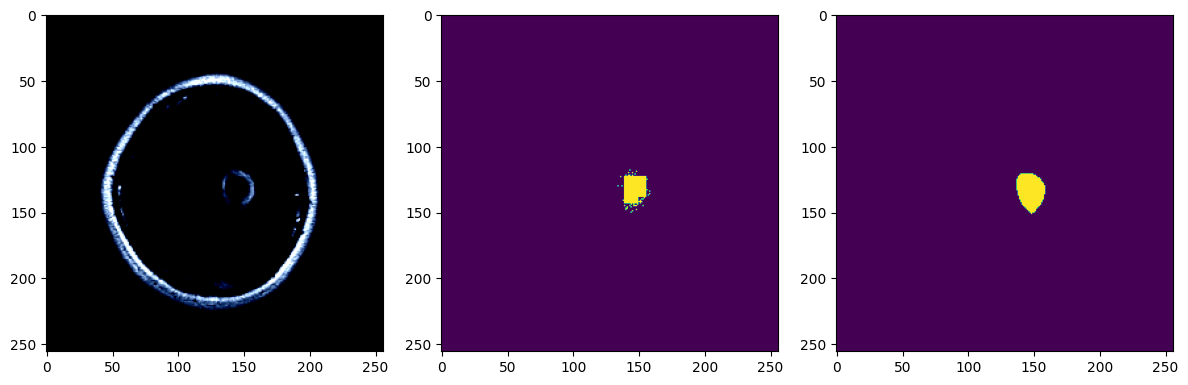

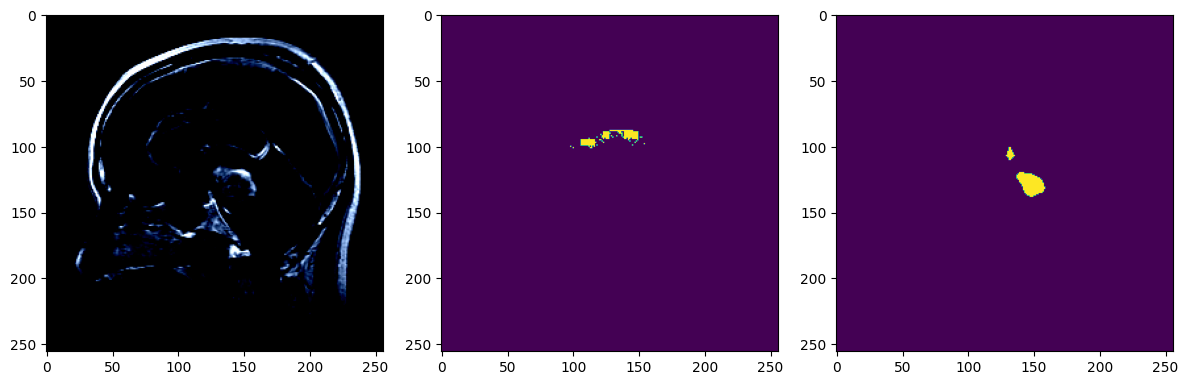

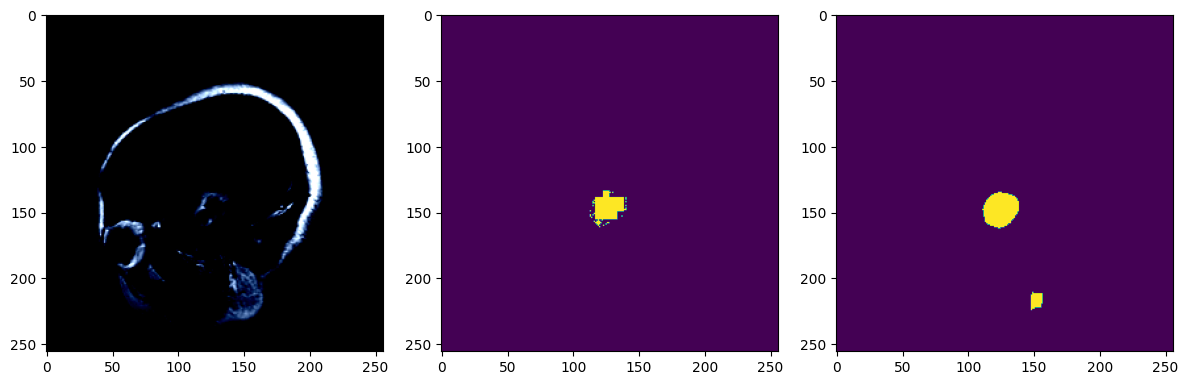

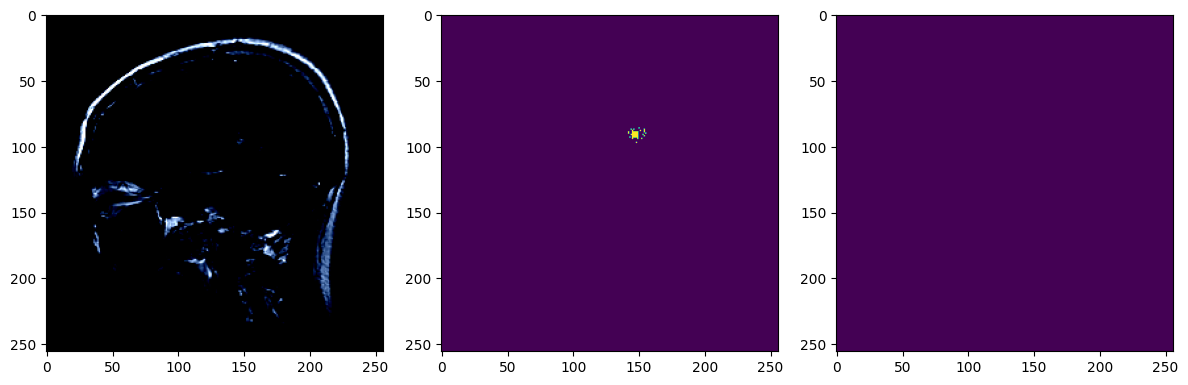

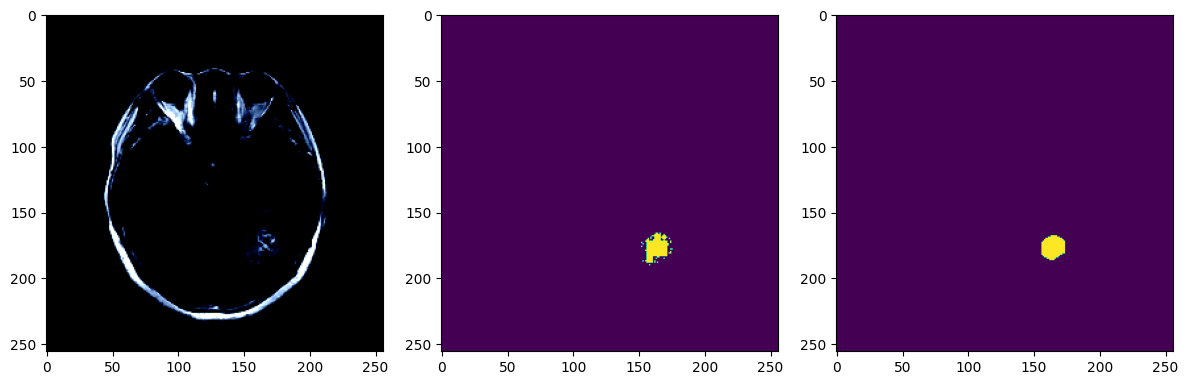

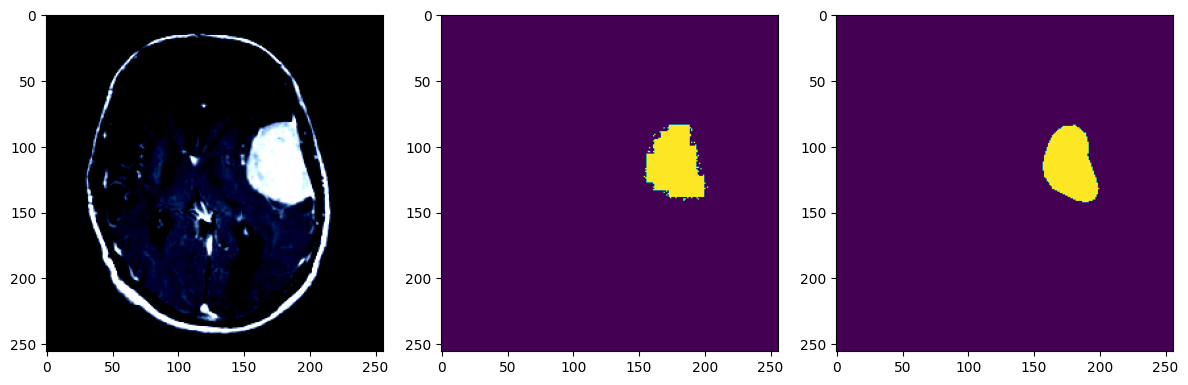

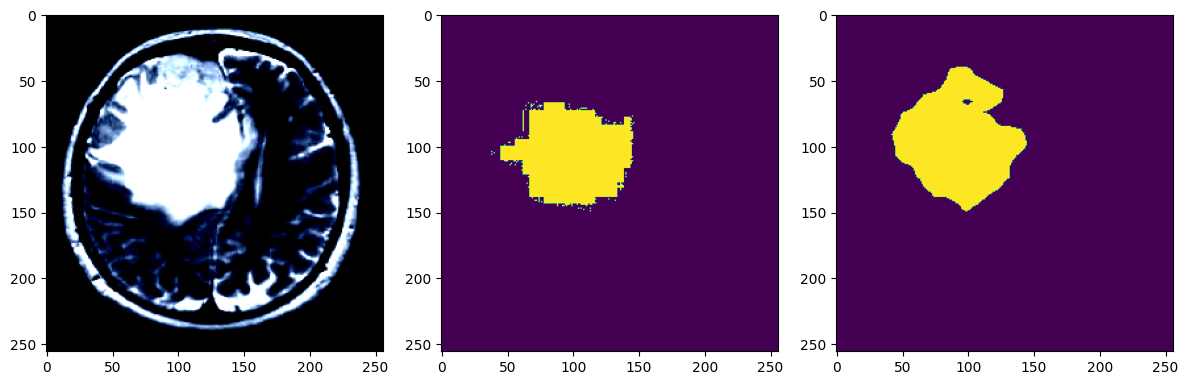

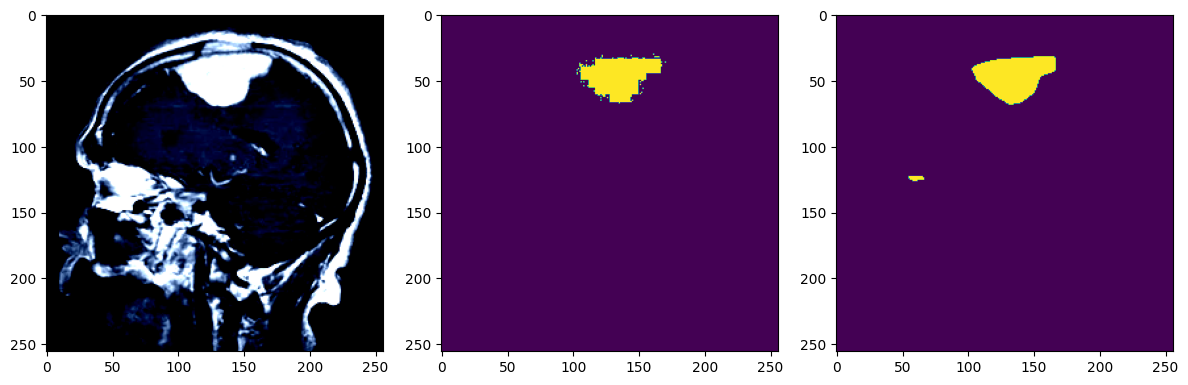

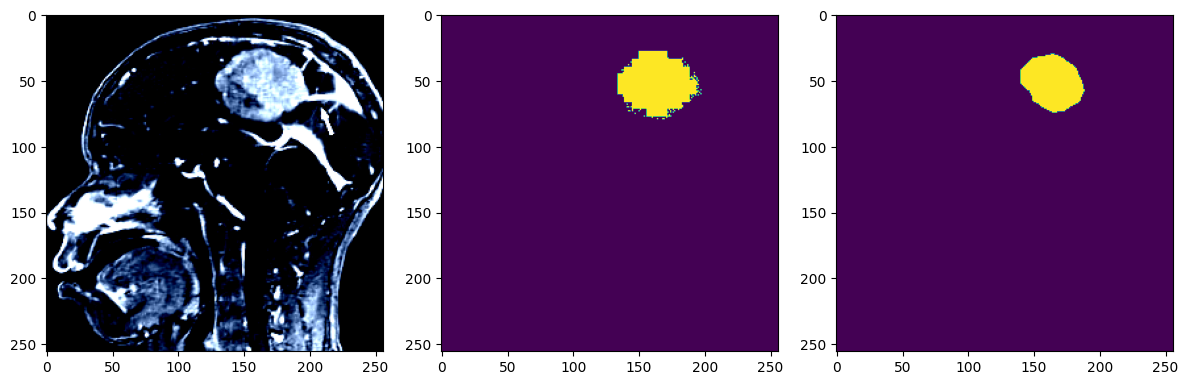

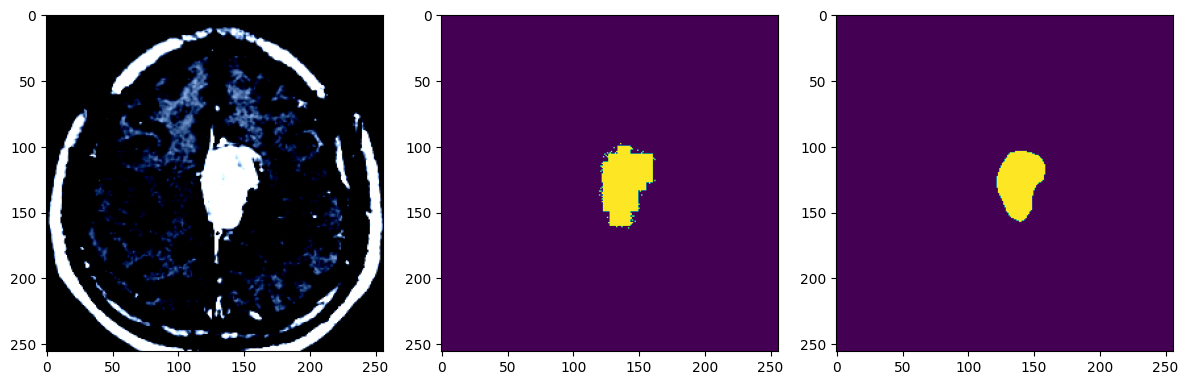

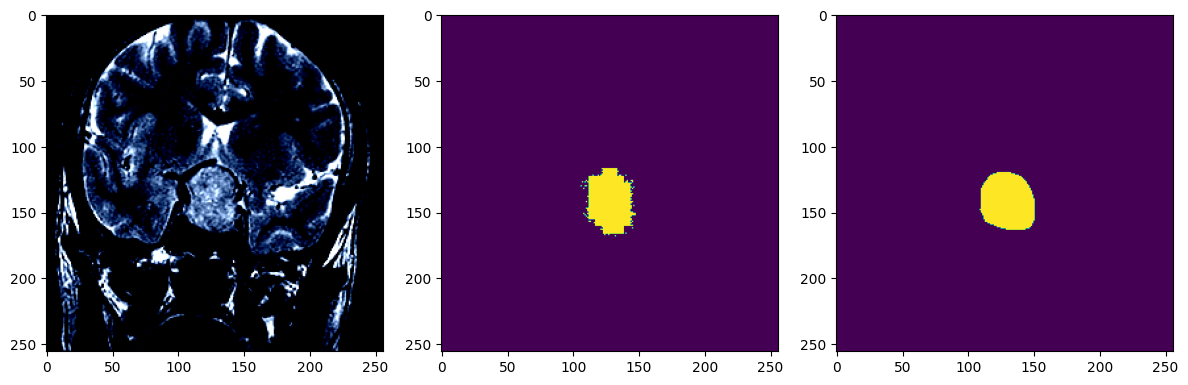

In [24]:
import torch
import numpy as np

with torch.no_grad():
    for img, label in test_loader:
        img = img.cuda()
        label = label.cuda()

        outputs = model(img)
        _, preds = torch.max(outputs, 1)  # Convert outputs to binary predictions (segmentation)

        label = label[0, :, :].cpu().numpy()
        preds = preds[0, :, :].cpu().numpy()
        img = img[0, :, :].cpu().numpy().transpose(1, 2, 0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(img)

        axes[1].imshow(label)

        axes[2].imshow(preds)

        plt.tight_layout()
        plt.show()

## Model Trained



*   Encoder(ResNet),Decoder(U-Net): 0.8218
*   Encoder(ResNet),Decoder(FPN): 0.7299
*   Encoder(ResNet),Decoder(PSPNet): 0.7969

